In [1]:
from google.colab import files
import pandas as pd
import numpy as np
import io
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import StandardScaler
from numpy.linalg import eig
import random
from random import randrange
import time
from datetime import timedelta
from datetime import datetime
import math

warnings.filterwarnings('ignore')


In [2]:
uploaded = files.upload()

# convert the csv file to dataframe
df = pd.read_csv(io.BytesIO(uploaded['raw_data.csv']))

# iterating the columns
for col in df.columns:
    print(col)

Saving raw_data.csv to raw_data.csv
ID
FoodGroup
Descrip
Energy_kcal
Protein_g
Fat_g
Carb_g
Sugar_g
Fiber_g
VitA_mcg
VitB6_mg
VitB12_mcg
VitC_mg
VitE_mg
Folate_mcg
Niacin_mg
Riboflavin_mg
Thiamin_mg
Calcium_mg
Copper_mcg
Iron_mg
Magnesium_mg
Manganese_mg
Phosphorus_mg
Selenium_mcg
Zinc_mg
VitA_USRDA
VitB6_USRDA
VitB12_USRDA
VitC_USRDA
VitE_USRDA
Folate_USRDA
Niacin_USRDA
Riboflavin_USRDA
Thiamin_USRDA
Calcium_USRDA
Copper_USRDA
Magnesium_USRDA
Phosphorus_USRDA
Selenium_USRDA
Zinc_USRDA


Here is the list of all columns in the `raw_data.csv`. Each record contains a unique ID, foodGroup that it belongs to, its name (`Descrip`), energy in kcal and its nutrient values.

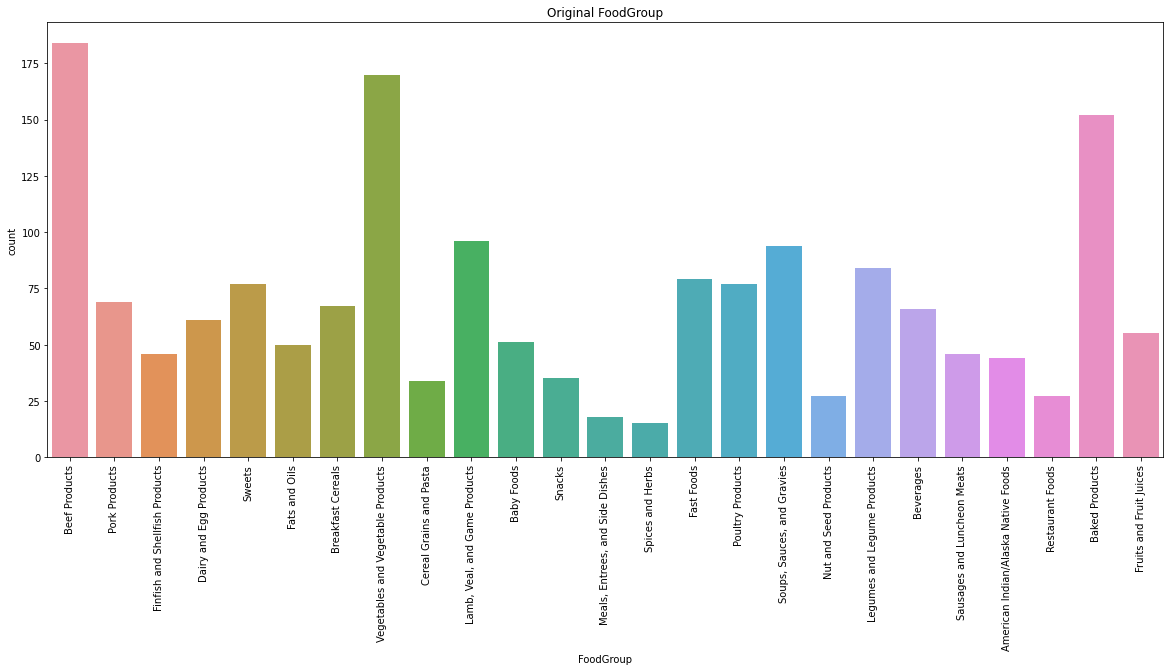

In [3]:
plt.figure(figsize = (20,8))
rawfgplot = sns.countplot(df.FoodGroup)
rawfgplot.set(title='Original FoodGroup')
fgplot = rawfgplot.set_xticklabels(rawfgplot.get_xticklabels(),rotation = 90)

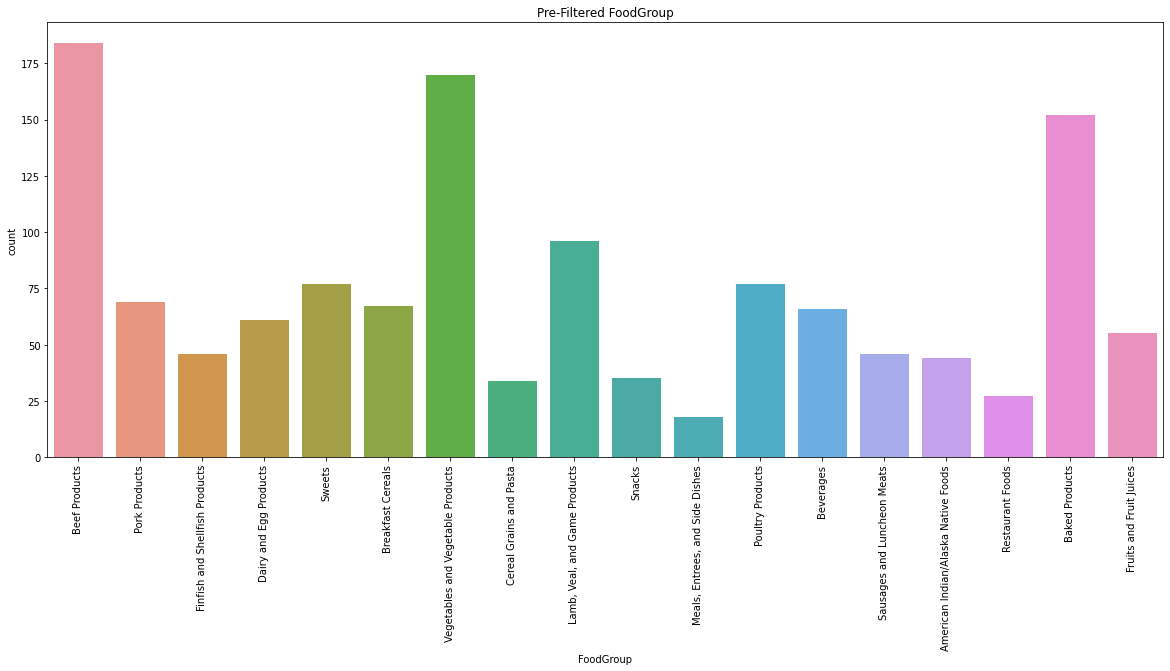

In [4]:
unused = ["Fats and Oils", "Baby Foods", "Spices and Herbs", "Soups, Sauces, and Gravies", "Nut and Seed Products", "Legumes and Legume Products", 'Fast Foods']

#drop rows that contain any value in the unused list
filtered_df = df[df.FoodGroup.isin(unused) == False]

plt.figure(figsize = (20,8))
rawfgplot = sns.countplot(filtered_df.FoodGroup)
rawfgplot.set(title='Pre-Filtered FoodGroup')
fgplot = rawfgplot.set_xticklabels(rawfgplot.get_xticklabels(),rotation = 90)

##AHP Sort: Generate weight values

In [5]:
def getEig(matrix):
  A = np.array(matrix)
  
  eigenvalues, eigenvector = np.linalg.eig(A)
  maxindex = np.argmax(eigenvalues)
  eigenvalues = np.float32(eigenvalues) #float32
  eigenvector = np.float32(eigenvector) #float32
  weights = eigenvector[:, maxindex]

  weights.tolist() #convert array(numpy) to vector
  weights = weights/np.sum(weights)

  # print("weight values for each criteria: ")
  # print(str(np.around(weights,4)))
  return weights


In [6]:
def AHP(A) -> np.array:
# Average random consistency index .
  RI_dict = {1: 0, 2: 0, 3: 0.58, 4: 0.90, 5: 1.12, 6: 1.24, 7: 1.32, 8: 1.41, 9: 1.45, 10: 1.49}
  n = len(A)
  for i in range(1, n):
    for k in range(i):
      A[i][k] = 1 / A[k][i]
  
  A = np.array(A)
  w, v = np.linalg.eig(A)
  lambda_max = np.max(abs(w))
  index = list(w).index(abs(w).max())
  CI = (lambda_max - n) / (n - 1)
  RI = RI_dict[n]
  CR = CI / RI
  y = 0
  if CR < 0.1:
    print(" The random consistency index is {}, The judgment matrix has satisfactory consistency .".format(CR))
    x = v[:, index].sum(axis=0) # Sum the column vectors , Sum the first column
    y = v[:, index] / x # The first column is normalized
    print(" The largest eigenvalue is ：", lambda_max)
    print(" The corresponding eigenvector is ：", abs(y).round(4))
  else:
    print(" The random consistency index is {}, The judgment matrix does not have satisfactory consistency .".format(CR))
    print(" The weight of each index is ：", abs(y))
  return abs(y)

In [7]:
# pairwise comparison according to nutritionist
matrix = [[1, 0.5, 2, 0.5],
          [2, 1, 3, 1],
          [0.5, 1/3, 1, 1/2],
          [2, 1, 2, 1]]

A = np.array(matrix)

weights = AHP(matrix)

 The random consistency index is 0.01697010537090996, The judgment matrix has satisfactory consistency .
 The largest eigenvalue is ： 4.045819284501457
 The corresponding eigenvector is ： [0.1936 0.3564 0.1243 0.3257]


This means that the weights of protein, fat, sugar and carbohydrates are 0.1613, 0.129, 0.6452 and 0.0645. The consistency ratio < 0.1, which is approriate.

## User Profile

According to Yera, Alzahrani and Martinez (2017), the user profile of diabetic patients is as follow:

In [8]:
userprofile = np.array([100, 23.1, 50, 250])

With the above information, we can use multi-criteria decision analysis (MCDA) to filter those food from the nutritional aspect.

# Pre-Filter based on Nutrient values

In [9]:
def comparision(sample):
  criteria = ['Protein_g', 'Fat_g', 'Sugar_g', 'Carb_g']
  lp_al = []
  lp_pro = []

  for count in range(4):
    col = criteria[count]
    alternative = sample[col]
    if(alternative == 0):
      lp_al.append(0)
      lp_pro.append(1)
      continue
    v1 = userprofile[count]/alternative
    v2 = alternative/userprofile[count]
    matrixJ = [[1, v1],
           [v2, 1]]
    weightJ = getEig(matrixJ)
    lp_al.append(weightJ[0])
    lp_pro.append(weightJ[1])
  return lp_al, lp_pro

In [10]:
level1_df = pd.DataFrame() 
print(level1_df.empty)

for (idx, row) in filtered_df.iterrows():
  lp_al, lp_pro = comparision(row)
  value_al = np.dot(lp_al, weights)
  value_pro = np.dot(lp_pro, weights)
  if value_al >= value_pro:
    level1_df = level1_df.append(row, ignore_index = True)



True


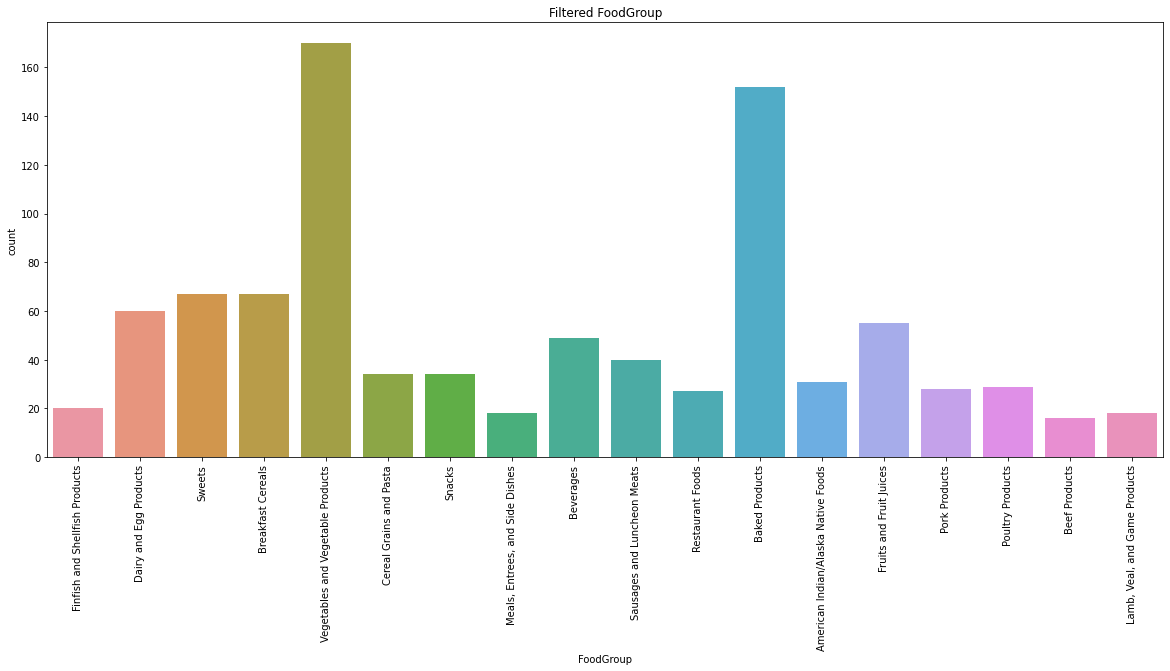

In [11]:
plt.figure(figsize = (20,8))
rawfgplot = sns.countplot(level1_df.FoodGroup)
rawfgplot.set(title='Filtered FoodGroup')
fgplot = rawfgplot.set_xticklabels(rawfgplot.get_xticklabels(),rotation = 90)

## Generate user dataset

In [12]:
!pip install names
import names

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 789 kB 4.8 MB/s 
  Created wheel for names: filename=names-0.3.0-py3-none-any.whl size=803699 sha256=a62897de0836de4beebca811c0aab98595894e1988d89ca6547378ed1dfcd7cc
  Stored in directory: /root/.cache/pip/wheels/05/ea/68/92f6b0669e478af9b7c3c524520d03050089e034edcc775c2b
Successfully built names


In [13]:
def random_date(start, end):
    delta = end - start
    int_delta = (delta.days * 24 * 60 * 60) + delta.seconds
    random_second = randrange(int_delta)
    return start + timedelta(seconds = random_second)

There are mainly 6 groups of food: Milk/yogurts, Breakfast cereals, fruits, proteins, vegetables and carbohydrates. We will first ask the users to tell the system 3~4 favorite food of each type.

In [14]:
def generateSample(group_no, food_list):
  cereal_list = ['Baked Products', 'Breakfast Cereals']
  protein_list = ['Dairy and Egg Products', 'Beef Products', 'Pork Products', 'Finfish and Shellfish Products', 'Sausages and Luncheon Meats', 'Poultry Products', 'Lamb, Veal, and Game Products']
  carbo_list = ['Dairy and Egg Products', 'Cereal Grains and Pasta', 'Fruits and Fruit Juices', 'Vegetables and Vegetable Products', 'Baked Products']
  group_list = ['Dairy and Egg Products', cereal_list, 'Fruits and Fruit Juices', protein_list, 'Vegetables and Vegetable Products', carbo_list]
  sample = level1_df.sample()
  
  group = group_list[group_no]
  if group_no%2 == 0:
    sample = level1_df.loc[level1_df['FoodGroup']==group].reset_index(drop=True).sample()
  else:
    sample = level1_df.loc[level1_df['FoodGroup'].isin(group)].reset_index(drop=True).sample()
  test = sample.iloc[0]['ID'] in food_list
  while(test):
    sample = generateSample(group_no, food_list)
    test = sample.iloc[0]['ID'] in food_list
    
  return sample

In [15]:
def generateExtraSample(food_list):
  sample = level1_df.sample()
  test = sample.iloc[0]['ID'] in food_list
  while(test):
    sample = level1_df.sample()
    test = sample.iloc[0]['ID'] in food_list
  return sample

In [16]:
def generateUserName(gender, name_list):
  random_name = names.get_first_name(gender=gender)
  test = random_name in name_list
  while(test):
    random_name = names.get_first_name(gender=gender)
    test = random_name in name_list
  return random_name

In [17]:
# RECORD_NO: tells how many records each user has
def generateUserLike(USER_NO, RECORD_NO):
  name_list = []
  gender_list = ['female', 'male']
  user_gender = []
  users_like = pd.DataFrame(columns=['name','gender','food ID','Descrip'])

  # there are 50 users
  for loop in range(USER_NO):
    random_gender = random.choice(gender_list)
    random_name = generateUserName(random_gender, name_list)
    name_list.append(random_name)
    user_gender.append(random_gender)
    ID_list = []
    # count will count how many record has been added
    count = 0
    count_test = False

    for group_no in range(0,6):
      if count >= RECORD_NO or count_test:
        break
      for i in range(random.randint(3,4)):
        sample = generateSample(group_no, ID_list)
        sample_id = sample.iloc[0]['ID']
        sample_name = sample.iloc[0]['Descrip']
        ID_list.append(sample_id)
        # store into users_like
        users_like.at[loop*RECORD_NO+count, 'name'] = random_name
        users_like.at[loop*RECORD_NO+count, 'gender'] = random_gender
        users_like.at[loop*RECORD_NO+count, 'food ID'] = sample_id
        users_like.at[loop*RECORD_NO+count, 'Descrip'] = sample_name
        count += 1
        if count >= RECORD_NO:
          count_test = True
          break
    
    
    while (count < RECORD_NO):
      sample = generateExtraSample(ID_list)
      sample_id = sample.iloc[0]['ID']
      sample_name = sample.iloc[0]['Descrip']
      ID_list.append(sample_id)
      users_like.at[loop*RECORD_NO+count, 'name'] = random_name
      users_like.at[loop*RECORD_NO+count, 'gender'] = random_gender
      users_like.at[loop*RECORD_NO+count, 'food ID'] = sample_id
      users_like.at[loop*RECORD_NO+count, 'Descrip'] = sample_name
      count += 1
      
  return name_list, user_gender, users_like

In [18]:
def compete(like, sample, weight):
  sample_id = sample.iloc[0]['ID']
  id_list = like['food ID'].unique().tolist()
  if sample_id in id_list:
    return sample
  else:
    id_list.append(sample_id)
    size = len(id_list)
    weight_list = []
    for i in range(size-1):
      weight_list.append(10)
    weight_list.append(weight)
    weight_list = tuple(weight_list)
    choice_list = random.choices(
        id_list, weights=weight_list, k=1)
    choice_id = choice_list[0]
    new_sample = level1_df.loc[level1_df['ID'] == choice_id]
    return new_sample

In [19]:
users = pd.DataFrame(columns=['name','gender','height_cm','weight_kg','age','food ID','Descrip','last eat timestamp','frequency_day'])
RECORD_NO = 100

start = datetime.strptime('3/1/2022 7:30 AM', '%m/%d/%Y %I:%M %p')
end = datetime.strptime('3/8/2022 11:00 PM', '%m/%d/%Y %I:%M %p')
current = datetime.strptime('3/10/2022 4:00 PM', '%m/%d/%Y %I:%M %p')
base = datetime.strptime('3/1/2022 7:30 AM', '%m/%d/%Y %I:%M %p')

# generate 50 users, each of them has 20 favourite food
user_name, user_gender, user_like = generateUserLike(50, 20)

for loop in range(50):
  # food_record is a list to record (ID, day) so that there will not be same food record in same day!
  food_record = []
  random_gender = user_gender[loop]
  random_name = user_name[loop]
  random_like = user_like.loc[user_like['name'] == random_name]
  if random_gender=='female':
    random_height = random.randint(150,175)
    random_weight = random.randint(40,70)
  else:
    random_height = random.randint(160,185)
    random_weight = random.randint(50,80)
  random_age = random.randint(18,50)
  for count in range(RECORD_NO):
    sample = level1_df.sample()

    choice = compete(random_like, sample, 50)

    sample_id = choice.iloc[0]['ID']
    sample_name = choice.iloc[0]['Descrip']
    sample_date = random_date(start, end)

    test = (sample_id, sample_date.date()) in food_record
    t = 0

    while(test):

      # if iterate over 10 times, consider change sample
      if (t>=5):
        sample = level1_df.sample()
        choice = compete(random_like, sample, 50)

        sample_id = choice.iloc[0]['ID']
        sample_name = choice.iloc[0]['Descrip']
      
      sample_date = random_date(start, end)
      test = (sample_id, sample_date.date()) in food_record
      t += 1
    
    food_record.append((sample_id, sample_date.date()))
    
    users.at[loop*RECORD_NO+count, 'name'] = random_name
    users.at[loop*RECORD_NO+count, 'gender'] = random_gender
    users.at[loop*RECORD_NO+count, 'height_cm'] = random_height
    users.at[loop*RECORD_NO+count, 'weight_kg'] = random_weight
    users.at[loop*RECORD_NO+count, 'age'] = random_age
    users.at[loop*RECORD_NO+count, 'food ID'] = sample_id
    users.at[loop*RECORD_NO+count, 'Descrip'] = sample_name
    users.at[loop*RECORD_NO+count, 'last eat timestamp'] = sample_date
    users.at[loop*RECORD_NO+count, 'frequency_day'] = random.randint(1,3)


In [20]:
users

,name,gender,height_cm,weight_kg,age,food ID,Descrip,last eat timestamp,frequency_day
0,Tonya,female,154,46,48,8449.0,"Cereals, QUAKER, Instant Grits Product with Am...",2022-03-08 19:59:24,3
1,Tonya,female,154,46,48,15017.0,"Fish, cod, Atlantic, canned, solids and liquid",2022-03-02 19:08:40,3
2,Tonya,female,154,46,48,11096.0,"Broccoli raab, raw",2022-03-07 14:06:08,3
3,Tonya,female,154,46,48,9434.0,"Guanabana nectar, canned",2022-03-06 08:46:57,3
4,Tonya,female,154,46,48,35154.0,"Salmonberries, raw (Alaska Native)",2022-03-06 19:49:59,1
...,...,...,...,...,...,...,...,...,...
4995,Katherine,female,153,64,47,11497.0,"Succotash, (corn and limas), canned, with crea...",2022-03-04 10:44:12,1
4996,Katherine,female,153,64,47,11827.0,"Pokeberry shoots, (poke), cooked, boiled, drai...",2022-03-02 08:50:10,2
4997,Katherine,female,153,64,47,7205.0,"OSCAR MAYER, Bologna Light (pork, chicken, beef)",2022-03-08 20:08:19,1
4998,Katherine,female,153,64,47,11770.0,"Corn, sweet, yellow, cooked, boiled, drained, ...",2022-03-03 02:20:59,3


user_like is a dataframe recording top 20 favorite food of each user.

In [21]:
user_like

,name,gender,food ID,Descrip
0,Tonya,female,1077.0,"Milk, whole, 3.25% milkfat, with added vitamin D"
1,Tonya,female,1070.0,"Dessert topping, powdered"
2,Tonya,female,43261.0,"Yogurt, fruit variety, nonfat"
3,Tonya,female,18567.0,"KRAFT, STOVE TOP Stuffing Mix Chicken Flavor"
4,Tonya,female,18630.0,"PILLSBURY, Chocolate Chip Cookies, refrigerate..."
...,...,...,...,...
995,Katherine,female,11487.0,"Squash, winter, butternut, frozen, unprepared"
996,Katherine,female,11096.0,"Broccoli raab, raw"
997,Katherine,female,11497.0,"Succotash, (corn and limas), canned, with crea..."
998,Katherine,female,11770.0,"Corn, sweet, yellow, cooked, boiled, drained, ..."


# Filter based on User Preferences

### Preparation of the User Weight Table

In [22]:
# food_record is all records of one food
def getFrequency(food_record):
  if(len(food_record)<=1):
    return food_record.iloc[0]['frequency_day']
  else:
    frequency = 0
    frequency_list=[]
    feature_list=[]
    for (idx, row) in food_record.iterrows():
      temp_time = row['last eat timestamp']
      relative_temp_time = time.mktime(temp_time.timetuple())-time.mktime(base.timetuple())
      relative_current_time = time.mktime(current.timetuple())-time.mktime(base.timetuple())
      relative_weight = relative_temp_time/relative_current_time
      feature_list.append(relative_weight)
      frequency_list.append(row['frequency_day'])
    total = sum(feature_list)
    for i in range(len(frequency_list)):
      frequency += feature_list[i]*frequency_list[i]/total
    return frequency

In [23]:
# user_record is the dataframe which contains all records for one user
# food_record only contains one line data for certain food
def calculateW(user_record, food_record, theta):
  taken_food = user_record['food ID'].tolist()
  ID = food_record.iloc[0]['ID']
  frequency = 0
  difference = 1
  if ID in taken_food: # record found in user record
    selected = user_record.loc[user_record['food ID']==ID].reset_index()
    frequency = getFrequency(selected)
    if(len(selected)>1): # more than one record for this food
      last = selected.at[0, 'last eat timestamp'] # initial value
      for (idx, row) in selected.iterrows():
        temp = row['last eat timestamp']
        if max(temp, last)==temp: #temp is 'latest'
          last = temp
    else:
      last = selected.iloc[0]['last eat timestamp']
    # relative timestamp difference
    tc = time.mktime(current.timetuple()) - time.mktime(base.timetuple())
    tk = time.mktime(last.timetuple()) - time.mktime(base.timetuple())
    difference = tk/tc
      
  weight = frequency*(math.exp(0.5*(1-difference))-1)
  #weight = frequency*(math.exp(0.5*(difference))-1)
  return weight

In [24]:
data = {'name':['Tom','Tom','Tom','Tom','Tom'], 'age':[31, 31, 31, 31, 31], 'height_cm':[172, 172, 172, 172, 172], 
                          'weight_kg':[61,61,61,61,61], 'food ID':[28155.0, 28152.0, 28155.0, 9415.0, 11286.0], 
                          'last eat timestamp':[random_date(start, end), random_date(start, end), random_date(start, end), random_date(start, end), random_date(start, end)], 'frequency_day':[3,4,2,1,3]}

user_test = pd.DataFrame(data)

In [25]:
user_test

,name,age,height_cm,weight_kg,food ID,last eat timestamp,frequency_day
0,Tom,31,172,61,28155.0,2022-03-01 16:43:38,3
1,Tom,31,172,61,28152.0,2022-03-07 06:13:24,4
2,Tom,31,172,61,28155.0,2022-03-07 01:05:39,2
3,Tom,31,172,61,9415.0,2022-03-06 07:14:21,1
4,Tom,31,172,61,11286.0,2022-03-08 03:15:32,3


In [26]:
food1 = pd.DataFrame({'ID':[28155], 'Descrip':['KEEBLER, Waffle Bowls']})
food1

,ID,Descrip
0,28155,"KEEBLER, Waffle Bowls"


case 1: multiple record for one food

In [27]:
weight = calculateW(user_test, food1, 0.5)
print("weight of test for food ID 28155 is: ", weight)

weight of test for food ID 28155 is:  0.4405315166647546


case 2: one record for one food

In [28]:
food2 = pd.DataFrame({'ID':[9415], 'Descrip':['Pears, raw, green anjou']})
weight = calculateW(user_test, food2, 0.5)
print("weight of test for food ID 9415 is: ", weight)

weight of test for food ID 9415 is:  0.2627859372823278


case 3: no record for one food

In [29]:
food3 = pd.DataFrame({'ID':[11830], 'Descrip':['Potatoes, baked, skin, with salt']})
weight = calculateW(user_test, food3, 0.5)
print("weight of test for food ID 11830 is: ", weight)

weight of test for food ID 11830 is:  0.0


### Get user preferences (`weight`) from each user (one user)

We shall first generate user preferences for one user to see if it works

In [30]:
# loop means which user, e.g., loop = 0 means first user in record, loop = 1 means second user...
# current_record is an optional parameter
def getWeightRecord(loop, theta, current_record):
  FOOD_NO = len(level1_df)
  user_record = users.iloc[loop*RECORD_NO: (loop+1)*RECORD_NO]

  if len(current_record) != 0:
    user_record = current_record

  # iterate over food records dataset
  for (idx, row) in level1_df.iterrows():
    food_record = pd.DataFrame(row).T.reset_index()
    weight = calculateW(user_record, food_record , theta)
    # weight_record.at[loop*FOOD_NO+idx, 'name'] = user_record.at[loop*RECORD_NO, 'name']
    weight_record.at[loop*FOOD_NO+idx, 'name'] = user_record.iloc[loop*RECORD_NO]['name']
    weight_record.at[loop*FOOD_NO+idx, 'gender'] = user_record.iloc[loop*RECORD_NO]['gender']
    weight_record.at[loop*FOOD_NO+idx, 'height_cm'] = user_record.iloc[loop*RECORD_NO]['height_cm']
    weight_record.at[loop*FOOD_NO+idx, 'weight_kg'] = user_record.iloc[loop*RECORD_NO]['weight_kg']
    weight_record.at[loop*FOOD_NO+idx, 'age'] = user_record.iloc[loop*RECORD_NO]['age']
    weight_record.at[loop*FOOD_NO+idx, 'ID'] = food_record.at[0, 'ID']
    weight_record.at[loop*FOOD_NO+idx, 'Descrip'] = food_record.at[0, 'Descrip']
    weight_record.at[loop*FOOD_NO+idx, 'weight'] = weight
    weight_record.at[loop*FOOD_NO+idx, 'Energy_kcal'] = food_record.at[0, 'Energy_kcal']
    weight_record.at[loop*FOOD_NO+idx, 'Protein_g'] = food_record.at[0, 'Protein_g']
    weight_record.at[loop*FOOD_NO+idx, 'Fat_g'] = food_record.at[0, 'Fat_g']
    weight_record.at[loop*FOOD_NO+idx, 'Carb_g'] = food_record.at[0, 'Carb_g']
    weight_record.at[loop*FOOD_NO+idx, 'Sugar_g'] = food_record.at[0, 'Sugar_g']
  return weight_record

In [31]:
#initialize weight record dataset
weight_record = pd.DataFrame(columns=['name','gender','height_cm','weight_kg','age','ID','Descrip','weight','Energy_kcal','Protein_g', 'Fat_g', 'Carb_g', 'Sugar_g'])

initial = pd.DataFrame(columns=['name','gender','height_cm','weight_kg','age','food ID','Descrip','last eat timestamp','frequency_day'])
weight_record = getWeightRecord(0, 0.5, initial)
weight_record

,name,gender,height_cm,weight_kg,age,ID,Descrip,weight,Energy_kcal,Protein_g,Fat_g,Carb_g,Sugar_g
0,Tonya,female,154,46,48,15270.0,"Crustaceans, shrimp, untreated, raw",0.0,85.0,20.1,0.51,0.0,0.0
1,Tonya,female,154,46,48,1259.0,"Cheese spread, American or Cheddar cheese base...",0.365675,176.0,13.41,8.88,10.71,7.06
2,Tonya,female,154,46,48,19100.0,"Candies, fudge, chocolate, prepared-from-recipe",0.0,411.0,2.39,10.41,76.44,73.12
3,Tonya,female,154,46,48,8228.0,"Cereals, QUAKER, Instant Oatmeal, raisins, dat...",0.0,371.0,8.82,6.98,72.41,30.85
4,Tonya,female,154,46,48,11850.0,"Radishes, oriental, cooked, boiled, drained, w...",0.0,17.0,0.67,0.24,3.43,1.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...
910,Tonya,female,154,46,48,36403.0,"Restaurant, Latino, empanadas, beef, prepared",0.0,335.0,11.31,18.37,31.19,1.84
911,Tonya,female,154,46,48,8015.0,"Cereals ready-to-eat, POST, COCOA PEBBLES",0.0,397.0,4.8,4.1,85.7,35.8
912,Tonya,female,154,46,48,19811.0,"Snacks, potato chips, plain, unsalted",0.0,536.0,7.0,34.6,52.9,0.22
913,Tonya,female,154,46,48,11863.0,"Squash, winter, all varieties, cooked, baked, ...",0.0,37.0,0.89,0.35,8.85,3.3


Here we get the result of one user preference. We can see that there are lots of zero in `weight`. This is because each user only contains 100 records and there might be duplicated records for the same food. If there is no record for one food, its frequency will be considered as 0, which is the reason why weight = 0

Next step we will select those rows that their weight are non-zero values

In [32]:
weight_record.loc[weight_record['weight'] != 0]

,name,gender,height_cm,weight_kg,age,ID,Descrip,weight,Energy_kcal,Protein_g,Fat_g,Carb_g,Sugar_g
1,Tonya,female,154,46,48,1259.0,"Cheese spread, American or Cheddar cheese base...",0.365675,176.0,13.41,8.88,10.71,7.06
13,Tonya,female,154,46,48,8449.0,"Cereals, QUAKER, Instant Grits Product with Am...",0.308947,360.0,8.8,4.67,74.18,2.02
52,Tonya,female,154,46,48,22999.0,"Rice and vermicelli mix, chicken flavor, prepa...",1.178425,136.0,2.65,3.45,23.54,0.64
64,Tonya,female,154,46,48,8560.0,"Cereals ready-to-eat, KASHI GO LEAN CRUNCH!, H...",0.259343,379.0,16.79,9.9,66.9,22.2
104,Tonya,female,154,46,48,1043.0,"Cheese, pasteurized process, pimento",0.238703,375.0,22.13,31.2,1.73,0.62
116,Tonya,female,154,46,48,1014.0,"Cheese, cottage, nonfat, uncreamed, dry, large...",0.629634,72.0,10.34,0.29,6.66,1.85
123,Tonya,female,154,46,48,11174.0,"Corn, sweet, yellow, canned, cream style, regu...",1.194349,72.0,1.74,0.42,18.13,3.23
143,Tonya,female,154,46,48,35154.0,"Salmonberries, raw (Alaska Native)",0.227858,47.0,0.85,0.33,10.05,3.66
164,Tonya,female,154,46,48,36006.0,"T.G.I. FRIDAY'S, FRIDAY'S Shrimp, breaded",0.362334,302.0,11.87,19.02,20.87,0.0
181,Tonya,female,154,46,48,22970.0,"Macaroni and cheese, frozen entree",1.468303,149.0,5.6,6.41,17.28,1.53


We can see that there are 98 rows containing non-zero weight. We shall use the weight table to generate meal plan for this user

### Generate meal plans for target user

#### **Breakfast**

According to Yera, Alzahrani, Martinez (2017), a classical breakfast template contains 1 food from `Dairy and Egg Products`, 1 food from `Breakfast Cereals` and 1 food from `Fruits and Fruit Juices`. Thus, we firstly can randomly generate set from these 3 groups and then use mathematical models to select the best ones from them

In [33]:
milk = level1_df.loc[level1_df['FoodGroup'] == 'Dairy and Egg Products'].reset_index()
milk.head()

,index,ID,FoodGroup,Descrip,Energy_kcal,Protein_g,Fat_g,Carb_g,Sugar_g,Fiber_g,...,Folate_USRDA,Niacin_USRDA,Riboflavin_USRDA,Thiamin_USRDA,Calcium_USRDA,Copper_USRDA,Magnesium_USRDA,Phosphorus_USRDA,Selenium_USRDA,Zinc_USRDA
0,1,1259.0,Dairy and Egg Products,"Cheese spread, American or Cheddar cheese base...",176.0,13.41,8.88,10.71,7.06,0.0,...,0.000,0.009562,0.340000,0.031667,0.464167,0.000036,0.064286,1.330000,0.281818,0.164545
1,9,1071.0,Dairy and Egg Products,"Dessert topping, powdered, 1.5 ounce prepared ...",194.0,3.61,12.72,17.13,17.13,0.0,...,0.010,0.003750,0.090000,0.022500,0.075000,0.000013,0.023810,0.122857,0.087273,0.024545
2,30,43396.0,Dairy and Egg Products,"Cheese, cottage, lowfat, 1% milkfat, with vege...",67.0,10.90,1.00,3.00,3.00,0.0,...,0.025,0.006250,0.100000,0.008333,0.046667,0.000031,0.009524,0.182857,0.081818,0.026364
3,35,1219.0,Dairy and Egg Products,"Yogurt, fruit, lowfat, with low calorie sweete...",105.0,4.86,1.41,18.60,2.90,0.0,...,0.025,0.006562,0.138462,0.034167,0.126667,0.000089,0.038095,0.190000,0.056364,0.074545
4,96,1018.0,Dairy and Egg Products,"Cheese, edam",357.0,24.99,27.80,1.43,1.43,0.0,...,0.040,0.005125,0.299231,0.030833,0.609167,0.000040,0.071429,0.765714,0.263636,0.340909


In [34]:
cb_list = ['Breakfast Cereals', 'Baked Products']
cereals = level1_df.loc[level1_df['FoodGroup'].isin(cb_list)].reset_index()
cereals.head()

,index,ID,FoodGroup,Descrip,Energy_kcal,Protein_g,Fat_g,Carb_g,Sugar_g,Fiber_g,...,Folate_USRDA,Niacin_USRDA,Riboflavin_USRDA,Thiamin_USRDA,Calcium_USRDA,Copper_USRDA,Magnesium_USRDA,Phosphorus_USRDA,Selenium_USRDA,Zinc_USRDA
0,3,8228.0,Breakfast Cereals,"Cereals, QUAKER, Instant Oatmeal, raisins, dat...",371.0,8.82,6.98,72.41,30.85,6.9,...,0.9525,0.748000,0.782308,0.743333,0.247500,0.000404,0.219048,0.422857,0.298182,0.176364
1,6,8003.0,Breakfast Cereals,"Cereals ready-to-eat, KELLOGG, KELLOGG'S APPLE...",375.0,5.10,3.40,88.20,43.70,9.3,...,1.4850,1.118750,1.169231,1.116667,0.010000,0.000109,0.069048,0.100000,0.101818,0.490909
2,7,8204.0,Breakfast Cereals,"Cereals ready-to-eat, chocolate-flavored frost...",405.0,3.34,3.50,87.20,43.70,3.8,...,1.4675,1.102313,1.153077,1.102500,0.058333,0.000267,0.085714,0.201429,0.118182,0.050909
3,12,8582.0,Breakfast Cereals,"Cereals ready-to-eat, GENERAL MILLS, DORA THE ...",366.0,5.60,5.70,82.80,21.20,10.2,...,3.1150,1.156250,1.230769,1.166667,0.308333,0.000140,0.071429,0.105714,0.154545,1.263636
4,13,8449.0,Breakfast Cereals,"Cereals, QUAKER, Instant Grits Product with Am...",360.0,8.80,4.67,74.18,2.02,4.3,...,0.0000,0.508750,0.530769,0.633333,0.348333,0.000000,0.064286,0.108571,0.000000,0.038182


In [35]:
fruit = level1_df.loc[level1_df['FoodGroup'] == 'Fruits and Fruit Juices'].reset_index()
fruit.head()

,index,ID,FoodGroup,Descrip,Energy_kcal,Protein_g,Fat_g,Carb_g,Sugar_g,Fiber_g,...,Folate_USRDA,Niacin_USRDA,Riboflavin_USRDA,Thiamin_USRDA,Calcium_USRDA,Copper_USRDA,Magnesium_USRDA,Phosphorus_USRDA,Selenium_USRDA,Zinc_USRDA
0,53,9272.0,Fruits and Fruit Juices,"Pineapple, frozen, chunks, sweetened",86.0,0.40,0.10,22.20,21.10,1.1,...,0.0275,0.018750,0.023077,0.083333,0.007500,0.000110,0.023810,0.005714,0.001818,0.010000
1,65,9135.0,Fruits and Fruit Juices,"Grape juice, canned or bottled, unsweetened, w...",60.0,0.37,0.13,14.77,14.20,0.2,...,0.0000,0.008313,0.011538,0.014167,0.009167,0.000020,0.023810,0.020000,0.000000,0.006364
2,76,9270.0,Fruits and Fruit Juices,"Pineapple, canned, heavy syrup pack, solids an...",78.0,0.35,0.11,20.20,16.90,0.8,...,0.0125,0.017937,0.019231,0.075000,0.011667,0.000112,0.038095,0.010000,0.007273,0.010909
3,79,9144.0,Fruits and Fruit Juices,"Jackfruit, raw",95.0,1.72,0.64,23.25,19.08,1.5,...,0.0600,0.057500,0.042308,0.087500,0.020000,0.000084,0.069048,0.030000,0.000000,0.011818
4,89,9415.0,Fruits and Fruit Juices,"Pears, raw, green anjou",66.0,0.44,0.10,15.79,9.73,3.1,...,0.0000,0.009437,0.016923,0.008333,0.009167,0.000086,0.016667,0.018571,0.000000,0.009091


In [36]:
# randomly generate breakfast meals based on amount required
def getBreakfast(amount):
  breakfast = pd.DataFrame(columns=['DEP ID','DEP Descrip','BC ID','BC Descrip','FFC ID','FFC Descrip', 'Energy_kcal','Protein_g', 'Fat_g', 'Carb_g', 'Sugar_g'])
  for loop in range(amount):
    sampleM = milk.sample().reset_index()
    sampleC = cereals.sample().reset_index()
    sampleF = fruit.sample().reset_index()
    breakfast.at[loop, 'DEP ID'] = sampleM.at[0, 'ID']
    breakfast.at[loop, 'DEP Descrip'] = sampleM.at[0, 'Descrip']
    breakfast.at[loop, 'BC ID'] = sampleC.at[0, 'ID']
    breakfast.at[loop, 'BC Descrip'] = sampleC.at[0, 'Descrip']
    breakfast.at[loop, 'FFC ID'] = sampleF.at[0, 'ID']
    breakfast.at[loop, 'FFC Descrip'] = sampleF.at[0, 'Descrip']
    breakfast.at[loop, 'Energy_kcal'] = sampleM.at[0, 'Energy_kcal']+sampleC.at[0, 'Energy_kcal']+sampleF.at[0, 'Energy_kcal']
    breakfast.at[loop, 'Protein_g'] = sampleM.at[0, 'Protein_g']+sampleC.at[0, 'Protein_g']+sampleF.at[0, 'Protein_g']
    breakfast.at[loop, 'Fat_g'] = sampleM.at[0, 'Fat_g']+sampleC.at[0, 'Fat_g']+sampleF.at[0, 'Fat_g']
    breakfast.at[loop, 'Carb_g'] = sampleM.at[0, 'Carb_g']+sampleC.at[0, 'Carb_g']+sampleF.at[0, 'Carb_g']
    breakfast.at[loop, 'Sugar_g'] = sampleM.at[0, 'Sugar_g']+sampleC.at[0, 'Sugar_g']+sampleF.at[0, 'Sugar_g']
  return breakfast

In [37]:
breakfast = getBreakfast(1000)
breakfast

,DEP ID,DEP Descrip,BC ID,BC Descrip,FFC ID,FFC Descrip,Energy_kcal,Protein_g,Fat_g,Carb_g,Sugar_g
0,43396.0,"Cheese, cottage, lowfat, 1% milkfat, with vege...",8705.0,"Cereals ready-to-eat, KASHI GOLEAN Vanilla Gra...",9273.0,"Pineapple juice, canned or bottled, unsweetene...",450.0,32.76,3.71,85.96,30.77
1,1254.0,"Cheese food, pasteurized process, American, wi...",18271.0,"Ice cream cones, cake or wafer-type",9057.0,"Boysenberries, frozen, unsweetened",797.0,26.06,32.79,99.75,18.48
2,1001.0,"Butter, salted",8376.0,"Cereals ready-to-eat, KELLOGG, KELLOGG'S MARSH...",9041.0,"Bananas, dehydrated, or banana powder",1439.0,9.34,85.72,177.64,97.26
3,1043.0,"Cheese, pasteurized process, pimento",28074.0,"KEEBLER, E.L. FUDGE, Butter Flavored Cookies",9229.0,"Papaya nectar, canned",914.0,27.8,51.85,86.24,48.43
4,1251.0,"Cheese, Mexican blend",18970.0,"Tortillas, ready-to-bake or -fry, flour, shelf...",9258.0,"Pears, canned, extra heavy syrup pack, solids ...",752.0,31.74,36.22,76.27,3.89
...,...,...,...,...,...,...,...,...,...,...,...
995,1092.0,"Milk, dry, nonfat, instant, with added vitamin...",18127.0,"Cake, snack cakes, creme-filled, chocolate wit...",9174.0,"Loquats, raw",804.0,39.16,16.85,124.64,89.95
996,1219.0,"Yogurt, fruit, lowfat, with low calorie sweete...",8646.0,"Cereals ready-to-eat, BEAR NAKED Nut Cluster C...",9073.0,"Cherries, sweet, canned, light syrup pack, sol...",546.0,13.97,5.06,118.98,41.29
997,1096.0,"Milk, canned, evaporated, with added vitamin D...",8100.0,"Cereals, CREAM OF RICE, dry",9258.0,"Pears, canned, extra heavy syrup pack, solids ...",601.0,13.3,8.19,117.69,10.34
998,1193.0,KRAFT BREAKSTONE'S Reduced Fat Sour Cream,28091.0,"KEEBLER, FUDGE SHOPPE, Fudge Stripes, Oatmeal",9057.0,"Boysenberries, frozen, unsweetened",680.0,11.1,36.06,85.09,46.39


The suggested daily calories intake is calculated through Basal Metabolic Rate (BMR)

In [38]:
def getBMR(height, weight, age, gender):
  bmr = 10*weight + 6.25*height - 5*age
  if gender=='female':
    return bmr - 161
  else:
    return bmr + 5

In our case, the bmr for this user is:

In [39]:
target_user = users.iloc[0:1]
t_height = target_user.at[0, 'height_cm']
t_weight = target_user.at[0, 'weight_kg']
t_age = target_user.at[0, 'age']
t_gender = target_user.at[0, 'gender']
t_bmr = 1.5*getBMR(t_height, t_weight, t_age, t_gender)
print("age:", t_age, " gender:", t_gender, " height:", t_height, "cm weight:", t_weight, "kg")
print("bmr of target user: ", t_bmr)

age: 48  gender: female  height: 154 cm weight: 46 kg
bmr of target user:  1532.25


Normally, breakfast contributes 15% daily food intake. Thus, we can create a method named `filterBreakfast` to filter those breakfast meal which takes much more calories than suggested

In [40]:
# filter breakfast based on user bmr
def filterBreakfast(breakfast, bmr):
  # initialization
  filtered = pd.DataFrame(columns=['DEP ID','DEP Descrip','BC ID','BC Descrip','FFC ID','FFC Descrip', 'Energy_kcal','Protein_g', 'Fat_g', 'Carb_g', 'Sugar_g'])
  suggest = bmr*0.15
  least = 1200*0.15
  for (idx, row) in breakfast.iterrows():
    meal = pd.DataFrame(row).T.reset_index()
    if meal.iloc[0]['Energy_kcal'] <= suggest and meal.iloc[0]['Energy_kcal'] >= least:
      filtered = filtered.append(meal, ignore_index = True)
  return filtered

In [41]:
f_breakfast = filterBreakfast(breakfast, t_bmr)
f_breakfast

,DEP ID,DEP Descrip,BC ID,BC Descrip,FFC ID,FFC Descrip,Energy_kcal,Protein_g,Fat_g,Carb_g,Sugar_g,index
0,1281.0,"Yogurt, Greek, non fat, strawberry, CHOBANI",18374.0,"Leavening agents, yeast, baker's, compressed",9340.0,"Pears, asian, raw",227.0,16.93,2.25,40.37,17.91,77.0
1,1059.0,"Milk, filled, fluid, with blend of hydrogenate...",8123.0,"Cereals, oats, instant, fortified, plain, prep...",9106.0,"Fruit salad, (peach and pear and apricot and p...",219.0,6.03,4.88,39.18,0.46,173.0
2,1266.0,"Cheese, Swiss, nonfat or fat free",8236.0,"Cereals, QUAKER, Oat Bran, QUAKER/MOTHER'S Oat...",9174.0,"Loquats, raw",217.0,30.86,1.15,23.03,1.33,573.0
3,43396.0,"Cheese, cottage, lowfat, 1% milkfat, with vege...",8123.0,"Cereals, oats, instant, fortified, plain, prep...",9211.0,"Orange juice, chilled, includes from concentra...",182.0,13.95,2.48,25.94,11.77,738.0
4,1250.0,Nutritional supplement for people with diabete...,8103.0,"Cereals, CREAM OF WHEAT, regular (10 minute), ...",9271.0,"Pineapple, canned, extra heavy syrup pack, sol...",221.0,6.18,3.4,43.9,2.67,768.0


Here we get the filtered breakfast for this target user

#### **Lunch**

Similar procedure for lunch. For lunch, we need 1 food from group that mainly provide proteins, 2 food from group that mainly provide carbohydrates, 1 food from vegetales and 1 food from fruits


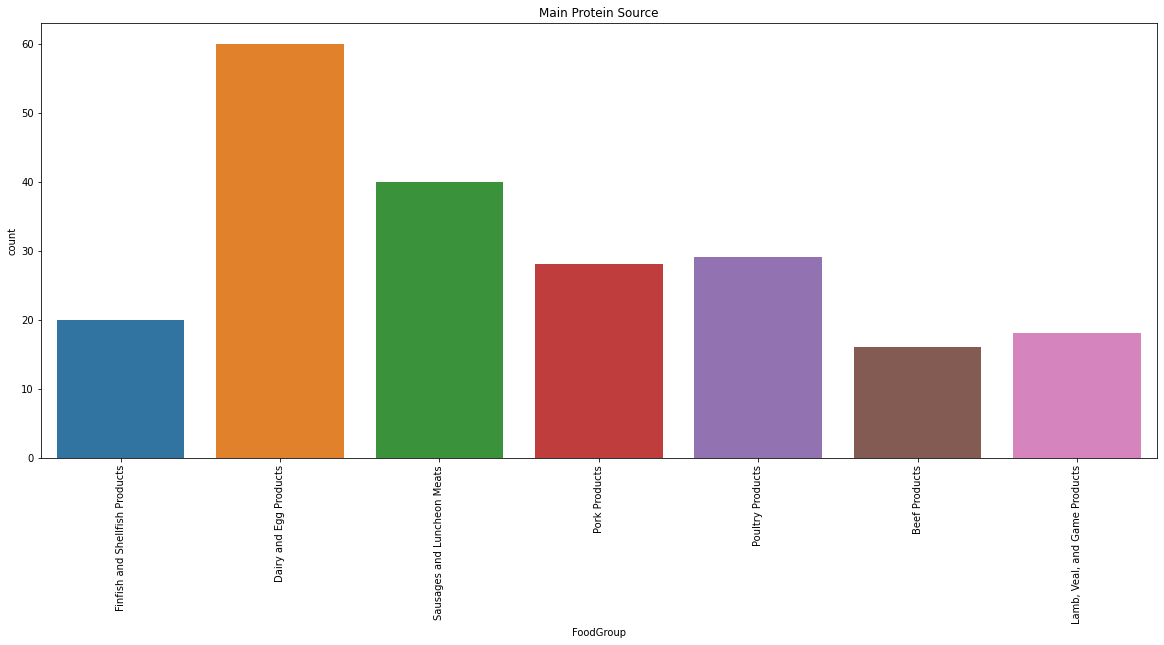

In [42]:
# group provide protein: Animal-based foods (meat, poultry, fish, eggs, and dairy foods)
protein_list = ['Dairy and Egg Products', 'Beef Products', 'Pork Products', 'Finfish and Shellfish Products', 'Sausages and Luncheon Meats', 'Poultry Products', 'Lamb, Veal, and Game Products']
protein = level1_df.loc[level1_df['FoodGroup'].isin(protein_list)].reset_index()

plt.figure(figsize = (20,8))
rawfgplot = sns.countplot(protein.FoodGroup)
rawfgplot.set(title='Main Protein Source')
fgplot = rawfgplot.set_xticklabels(rawfgplot.get_xticklabels(),rotation = 90)

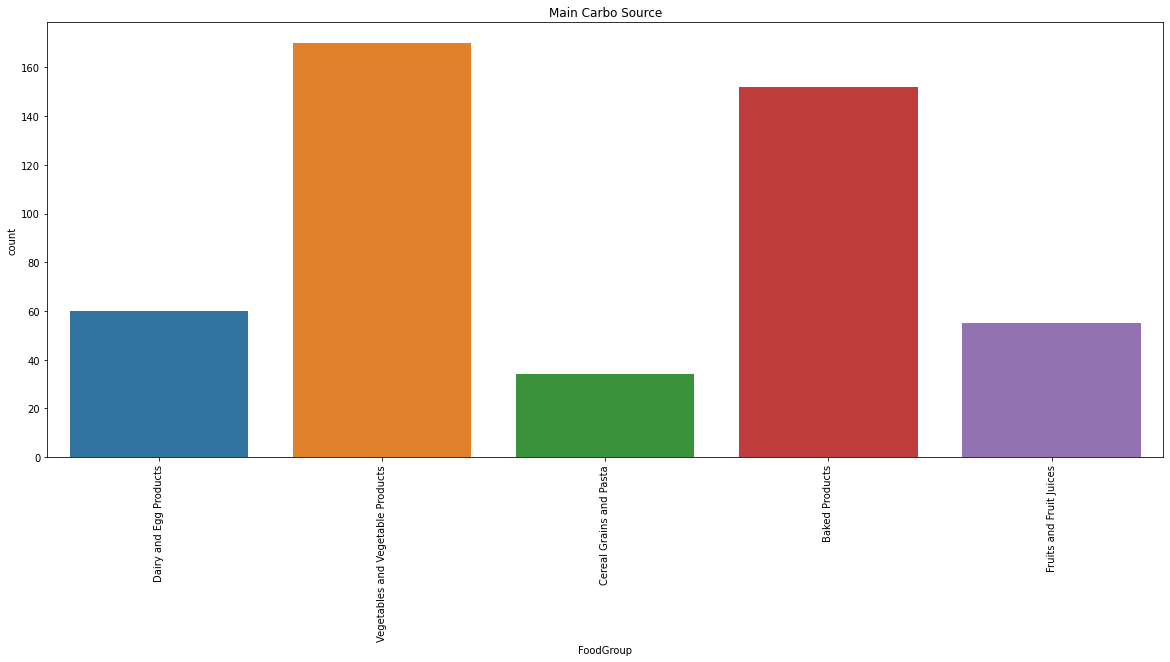

In [43]:
# group provide carbohydrates: Fruit, Milk and yogurt, Bread, cereal, rice, and pasta, Starchy vegetables like potatoes, corn, and beans
carbo_list = ['Dairy and Egg Products', 'Cereal Grains and Pasta', 'Fruits and Fruit Juices', 'Vegetables and Vegetable Products', 'Baked Products']
carbo = level1_df.loc[level1_df['FoodGroup'].isin(carbo_list)].reset_index()

plt.figure(figsize = (20,8))
rawfgplot = sns.countplot(carbo.FoodGroup)
rawfgplot.set(title='Main Carbo Source')
fgplot = rawfgplot.set_xticklabels(rawfgplot.get_xticklabels(),rotation = 90)

In [44]:
vegetable = level1_df.loc[level1_df['FoodGroup'] == 'Vegetables and Vegetable Products'].reset_index()

In [45]:
def getLunch(amount):
  lunch = pd.DataFrame(columns=['Protein ID','Protein Descrip','Carbo1 ID','Carbo1 Descrip','Carbo2 ID','Carbo2 Descrip','Vege ID','Vege Descrip', 'Fruit ID','Fruit Descrip','Energy_kcal','Protein_g', 'Fat_g', 'Carb_g', 'Sugar_g'])
  for loop in range(amount):
    sampleP = protein.sample().reset_index()
    sampleC1 = carbo.sample().reset_index()
    sampleC2 = carbo.sample().reset_index()
    sampleV = vegetable.sample().reset_index()
    sampleF = fruit.sample().reset_index()

    lunch.at[loop, 'Protein ID'] = sampleP.at[0, 'ID']
    lunch.at[loop, 'Protein Descrip'] = sampleP.at[0, 'Descrip']
    lunch.at[loop, 'Carbo1 ID'] = sampleC1.at[0, 'ID']
    lunch.at[loop, 'Carbo1 Descrip'] = sampleC1.at[0, 'Descrip']
    lunch.at[loop, 'Carbo2 ID'] = sampleC2.at[0, 'ID']
    lunch.at[loop, 'Carbo2 Descrip'] = sampleC2.at[0, 'Descrip']
    lunch.at[loop, 'Vege ID'] = sampleV.at[0, 'ID']
    lunch.at[loop, 'Vege Descrip'] = sampleV.at[0, 'Descrip']
    lunch.at[loop, 'Fruit ID'] = sampleF.at[0, 'ID']
    lunch.at[loop, 'Fruit Descrip'] = sampleF.at[0, 'Descrip']

    lunch.at[loop, 'Energy_kcal'] = sampleP.at[0, 'Energy_kcal']+sampleC1.at[0, 'Energy_kcal']+sampleC2.at[0, 'Energy_kcal']+sampleV.at[0, 'Energy_kcal']+sampleF.at[0, 'Energy_kcal']
    lunch.at[loop, 'Protein_g'] = sampleP.at[0, 'Protein_g']+sampleC1.at[0, 'Protein_g']+sampleC2.at[0, 'Protein_g']+sampleV.at[0, 'Protein_g']+sampleF.at[0, 'Protein_g']
    lunch.at[loop, 'Fat_g'] = sampleP.at[0, 'Fat_g']+sampleC1.at[0, 'Fat_g']+sampleC2.at[0, 'Fat_g']+sampleV.at[0, 'Fat_g']+sampleF.at[0, 'Fat_g']
    lunch.at[loop, 'Carb_g'] = sampleP.at[0, 'Carb_g']+sampleC1.at[0, 'Carb_g']+sampleC2.at[0, 'Carb_g']+sampleV.at[0, 'Carb_g']+sampleF.at[0, 'Carb_g']
    lunch.at[loop, 'Sugar_g'] = sampleP.at[0, 'Sugar_g']+sampleC1.at[0, 'Sugar_g']+sampleC2.at[0, 'Sugar_g']+sampleV.at[0, 'Sugar_g']+sampleF.at[0, 'Sugar_g']
  return lunch

In [46]:
lunch = getLunch(1000)
lunch

,Protein ID,Protein Descrip,Carbo1 ID,Carbo1 Descrip,Carbo2 ID,Carbo2 Descrip,Vege ID,Vege Descrip,Fruit ID,Fruit Descrip,Energy_kcal,Protein_g,Fat_g,Carb_g,Sugar_g
0,17199.0,"Lamb, variety meats and by-products, liver, raw",11467.0,"Squash, summer, crookneck and straightneck, raw",28208.0,"MOTHER'S, Peanut Butter Gauchos Cookies",11400.0,"Potatoes, frozen, whole, unprepared",9309.0,"Rhubarb, frozen, uncooked",739.0,31.72,27.56,93.93,37.06
1,1251.0,"Cheese, Mexican blend",11258.0,"Mountain yam, hawaii, raw",11943.0,"Pimento, canned",11244.0,"Lambsquarters, raw",9252.0,"Pears, raw",548.0,30.54,29.85,45.68,14.0
2,1260.0,"Cheese, cheddar, reduced fat",28198.0,"MOTHER'S, Double Fudge Creme Sandwich Cookies",11892.0,"Turnip greens, frozen, cooked, boiled, drained...",11378.0,"Potatoes, mashed, dehydrated, flakes without m...",9120.0,"Grapefruit, sections, canned, juice pack, soli...",1186.0,45.04,41.73,169.42,46.27
3,5722.0,"Turkey, retail parts, thigh, meat only, cooked...",18931.0,"USDA Commodity, Bakery, Flour Mix Low-fat",11852.0,"Salsify, cooked, boiled, drained, with salt",11717.0,"Lima beans, immature seeds, frozen, fordhook, ...",9273.0,"Pineapple juice, canned or bottled, unsweetene...",744.0,43.37,11.58,118.6,14.22
4,1260.0,"Cheese, cheddar, reduced fat",11361.0,"Potatoes, roasted, salt added in processing, f...",11258.0,"Mountain yam, hawaii, raw",43406.0,Yeast extract spread,9211.0,"Orange juice, chilled, includes from concentra...",738.0,55.47,23.34,78.2,11.17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1043.0,"Cheese, pasteurized process, pimento",18310.0,"Pie, chocolate creme, commercially prepared",18403.0,"Waffles, plain, frozen, ready -to-heat, toasted",11950.0,"Mushrooms, enoki, raw",9021.0,"Apricots, raw",1125.0,37.53,63.9,108.39,42.49
996,23185.0,"Beef, rib, back ribs, bone-in, separable lean ...",28006.0,"KELLOGG'S, CINNABON, Pancakes, Original",18312.0,"Pie, chocolate mousse, prepared from mix, no-b...",11748.0,"Butterbur, cooked, boiled, drained, with salt",9229.0,"Papaya nectar, canned",804.0,28.61,39.0,89.57,28.81
997,15163.0,"Mollusks, cuttlefish, mixed species, raw",11244.0,"Lambsquarters, raw",18313.0,"Pie, coconut creme, commercially prepared",11253.0,"Lettuce, green leaf, raw",9325.0,"Fruit salad, (pineapple and papaya and banana ...",521.0,24.31,18.35,70.65,19.3
998,7930.0,"Yachtwurst, with pistachio nuts, cooked",28006.0,"KELLOGG'S, CINNABON, Pancakes, Original",1116.0,"Yogurt, plain, whole milk, 8 grams protein per...",11632.0,"Peppers, jalapeno, canned, solids and liquids",9144.0,"Jackfruit, raw",709.0,25.91,35.13,77.15,40.78


In [47]:
def filterLunch(lunch, bmr):
  # initialization
  filtered = pd.DataFrame(columns=['Protein ID','Protein Descrip','Carbo1 ID','Carbo1 Descrip','Carbo2 ID','Carbo2 Descrip','Vege ID','Vege Descrip', 'Fruit ID','Fruit Descrip','Energy_kcal','Protein_g', 'Fat_g', 'Carb_g', 'Sugar_g'])
  suggest = bmr*0.45
  least = 1200*0.45
  for (idx, row) in lunch.iterrows():
    meal = pd.DataFrame(row).T.reset_index()
    if meal.iloc[0]['Energy_kcal'] <= suggest and meal.iloc[0]['Energy_kcal'] >= least:
      filtered = filtered.append(meal, ignore_index = True)
  return filtered

In [48]:
f_lunch = filterLunch(lunch, t_bmr)
f_lunch

,Protein ID,Protein Descrip,Carbo1 ID,Carbo1 Descrip,Carbo2 ID,Carbo2 Descrip,Vege ID,Vege Descrip,Fruit ID,Fruit Descrip,Energy_kcal,Protein_g,Fat_g,Carb_g,Sugar_g,index
0,1251.0,"Cheese, Mexican blend",11258.0,"Mountain yam, hawaii, raw",11943.0,"Pimento, canned",11244.0,"Lambsquarters, raw",9252.0,"Pears, raw",548.0,30.54,29.85,45.68,14.0,1.0
1,10926.0,"Pork, cured, ham with natural juices, slice, b...",1215.0,"Cheese product, pasteurized process, American,...",11596.0,"Winged beans, immature seeds, cooked, boiled, ...",11203.0,"Cress, garden, raw",9011.0,"Apples, dried, sulfured, uncooked",671.0,47.33,19.18,86.24,70.65,8.0
2,1193.0,KRAFT BREAKSTONE'S Reduced Fat Sour Cream,9514.0,"Juice Smoothie, BOLTHOUSE FARMS, BERRY BOOST",18262.0,"English muffins, raisin-cinnamon (includes app...",11366.0,"Potatoes, boiled, cooked in skin, skin, withou...",9150.0,"Lemons, raw, without peel",545.0,17.0,14.22,92.03,32.96,11.0
3,10134.0,"Pork, cured, ham, boneless, extra lean (approx...",18271.0,"Ice cream cones, cake or wafer-type",11943.0,"Pimento, canned",11122.0,"Cardoon, raw",9273.0,"Pineapple juice, canned or bottled, unsweetene...",655.0,31.19,12.95,102.54,18.69,24.0
4,23225.0,"Beef, plate steak, boneless, outside skirt, se...",11246.0,"Leeks, (bulb and lower leaf-portion), raw",9286.0,"Pomegranates, raw",11286.0,"Onions, yellow, sauteed",9252.0,"Pears, raw",571.0,22.17,30.85,56.29,27.32,26.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,1097.0,"Milk, canned, evaporated, nonfat, with added v...",28121.0,"KEEBLER, 100 Calorie RIGHT BITES, Sandies Shor...",11203.0,"Cress, garden, raw",11219.0,"Gourd, white-flowered (calabash), cooked, boil...",9183.0,"Melons, casaba, raw",615.0,15.96,21.12,99.52,48.44,968.0
180,23315.0,"Beef, Australian, grass-fed, loin, top sirloin...",11777.0,"Cowpeas (blackeyes), immature seeds, cooked, b...",20008.0,Buckwheat,11203.0,"Cress, garden, raw",9023.0,"Apricots, canned, water pack, without skin, so...",618.0,41.48,8.96,102.22,7.63,977.0
181,7909.0,"Luncheon meat, pork and chicken, minced, canne...",11738.0,"Broadbeans, immature seeds, cooked, boiled, dr...",11409.0,"Potatoes, frozen, french fried, par fried, ext...",11969.0,"Broccoli, chinese, cooked",9309.0,"Rhubarb, frozen, uncooked",634.0,25.27,33.94,60.04,3.2,980.0
182,7045.0,"Luncheon meat, pork, canned",9211.0,"Orange juice, chilled, includes from concentra...",11871.0,"Succotash, (corn and limas), cooked, boiled, d...",11908.0,"Corn, sweet, white, canned, vacuum pack, regul...",9013.0,"Apples, dried, sulfured, stewed, with added sugar",654.0,20.86,31.79,77.91,8.31,984.0


Here we get the filtered lunch for this target user

#### Dinner

For dinner, the composition of dinner is same as lunch.

In [49]:
dinner = getLunch(1000)

In [50]:
def filterDinner(dinner, bmr):
  # initialization
  filtered = pd.DataFrame(columns=['Protein ID','Protein Descrip','Carbo1 ID','Carbo1 Descrip','Carbo2 ID','Carbo2 Descrip','Vege ID','Vege Descrip', 'Fruit ID','Fruit Descrip','Energy_kcal','Protein_g', 'Fat_g', 'Carb_g', 'Sugar_g'])
  suggest = bmr*0.4
  least = 1200*0.4
  for (idx, row) in dinner.iterrows():
    meal = pd.DataFrame(row).T.reset_index()
    if meal.iloc[0]['Energy_kcal'] <= suggest and meal.iloc[0]['Energy_kcal'] >= least:
      filtered = filtered.append(meal, ignore_index = True)
  return filtered

In [51]:
f_dinner = filterDinner(dinner, t_bmr)
f_dinner

,Protein ID,Protein Descrip,Carbo1 ID,Carbo1 Descrip,Carbo2 ID,Carbo2 Descrip,Vege ID,Vege Descrip,Fruit ID,Fruit Descrip,Energy_kcal,Protein_g,Fat_g,Carb_g,Sugar_g,index
0,1166.0,"Cheese, mexican, queso asadero",11476.0,"Squash, summer, scallop, cooked, boiled, drain...",1281.0,"Yogurt, Greek, non fat, strawberry, CHOBANI",11791.0,"Kale, frozen, cooked, boiled, drained, with salt",9507.0,"Juice Smoothie, NAKED JUICE, MIGHTY MANGO",545.0,34.92,29.04,38.02,29.07,3.0
1,1186.0,"Cheese, cream, fat free",1226.0,"Egg substitute, liquid or frozen, fat free",11754.0,"Cabbage, chinese (pak-choi), cooked, boiled, d...",11634.0,"Peppers, sweet, green, freeze-dried",9023.0,"Apricots, canned, water pack, without skin, so...",501.0,45.84,4.19,85.62,46.79,5.0
2,1178.0,"Sour cream, reduced fat",11828.0,"Potatoes, baked, flesh and skin, with salt",11921.0,"Peppers, sweet, red, sauteed",11802.0,"New zealand spinach, cooked, boiled, drained, ...",9028.0,"Apricots, canned, heavy syrup pack, without sk...",502.0,12.35,27.24,58.3,6.01,8.0
3,17072.0,"Lamb, New Zealand, imported, leg chop/steak, b...",11914.0,"Corn, sweet, white, frozen, kernels on cob, co...",11497.0,"Succotash, (corn and limas), canned, with crea...",11794.0,"Lambs quarters, cooked, boiled, drained, with ...",9195.0,"Olives, pickled, canned or bottled, green",554.0,28.62,31.82,48.91,1.16,11.0
4,5089.0,"Chicken, broilers or fryers, neck, meat only, ...",11406.0,"Potatoes, french fried, cottage-cut, salt not ...",11243.0,"Mushrooms, portabella, grilled",11703.0,"Artichokes, (globe or french), frozen, cooked,...",9055.0,"Blueberries, frozen, sweetened",541.0,36.08,18.87,61.32,22.82,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,5101.0,"Chicken, broilers or fryers, wing, meat and sk...",1186.0,"Cheese, cream, fat free",11246.0,"Leeks, (bulb and lower leaf-portion), raw",11521.0,"Taro leaves, cooked, steamed, without salt",9106.0,"Fruit salad, (peach and pear and apricot and p...",602.0,40.11,23.58,59.54,9.38,964.0
147,43274.0,"Cheese, cream, low fat",11811.0,"Peas, green, cooked, boiled, drained, with salt",9119.0,"Grapefruit, sections, canned, water pack, soli...",11407.0,"Potatoes, french fried, cottage-cut, salt not ...",9183.0,"Melons, casaba, raw",567.0,18.34,23.9,73.52,26.19,973.0
148,5005.0,"Chicken, broilers or fryers, meat and skin and...",11220.0,"Gourd, dishcloth (towelgourd), raw",18262.0,"English muffins, raisin-cinnamon (includes app...",11198.0,"Cowpeas, young pods with seeds, cooked, boiled...",9023.0,"Apricots, canned, water pack, without skin, so...",532.0,36.89,14.7,64.99,16.78,986.0
149,15169.0,"Mollusks, oyster, eastern, wild, cooked, moist...",11788.0,"Hyacinth-beans, immature seeds, cooked, boiled...",20078.0,"Wheat germ, crude",11981.0,"Peppers, hungarian, raw",9309.0,"Rhubarb, frozen, uncooked",562.0,38.87,13.93,78.25,5.86,997.0


Here we get the filtered dinner for this target user

### Combine breakfast, lunch and dinner to set

In [52]:
def getSet(breakfast, lunch, dinner, amount):
  sets = pd.DataFrame(columns=['BID1','BID2','BID3','LID1','LID2','LID3','LID4','LID5','DID1','DID2','DID3','DID4','DID5','Energy_kcal','Protein_g', 'Fat_g', 'Carb_g', 'Sugar_g'])
  for loop in range(amount):
    sampleB = breakfast.sample().reset_index()
    sampleL = lunch.sample().reset_index()
    sampleD = dinner.sample().reset_index()

    sets.at[loop, 'BID1'] = sampleB.at[0, 'DEP ID']
    sets.at[loop, 'BID2'] = sampleB.at[0, 'BC ID']
    sets.at[loop, 'BID3'] = sampleB.at[0, 'FFC ID']

    sets.at[loop, 'LID1'] = sampleL.at[0, 'Protein ID']
    sets.at[loop, 'LID2'] = sampleL.at[0, 'Carbo1 ID']
    sets.at[loop, 'LID3'] = sampleL.at[0, 'Carbo2 ID']
    sets.at[loop, 'LID4'] = sampleL.at[0, 'Vege ID']
    sets.at[loop, 'LID5'] = sampleL.at[0, 'Fruit ID']

    sets.at[loop, 'DID1'] = sampleD.at[0, 'Protein ID']
    sets.at[loop, 'DID2'] = sampleD.at[0, 'Carbo1 ID']
    sets.at[loop, 'DID3'] = sampleD.at[0, 'Carbo2 ID']
    sets.at[loop, 'DID4'] = sampleD.at[0, 'Vege ID']
    sets.at[loop, 'DID5'] = sampleD.at[0, 'Fruit ID']

    sets.at[loop, 'Energy_kcal'] = sampleB.at[0, 'Energy_kcal']+sampleL.at[0, 'Energy_kcal']+sampleD.at[0, 'Energy_kcal']

    sets.at[loop, 'Protein_g'] = sampleB.at[0, 'Protein_g']+sampleL.at[0, 'Protein_g']+sampleD.at[0, 'Protein_g']
    sets.at[loop, 'Fat_g'] = sampleB.at[0, 'Fat_g']+sampleL.at[0, 'Fat_g']+sampleD.at[0, 'Fat_g']
    sets.at[loop, 'Carb_g'] = sampleB.at[0, 'Carb_g']+sampleL.at[0, 'Carb_g']+sampleD.at[0, 'Carb_g']
    sets.at[loop, 'Sugar_g'] = sampleB.at[0, 'Sugar_g']+sampleL.at[0, 'Sugar_g']+sampleD.at[0, 'Sugar_g']
  
  return sets

In [53]:
menu = getSet(f_breakfast, f_lunch, f_dinner, 2000).drop_duplicates()
menu

,BID1,BID2,BID3,LID1,LID2,LID3,LID4,LID5,DID1,DID2,DID3,DID4,DID5,Energy_kcal,Protein_g,Fat_g,Carb_g,Sugar_g
0,1266.0,8236.0,9174.0,7011.0,11908.0,18278.0,11827.0,9013.0,7052.0,20002.0,11927.0,11711.0,9195.0,1380.0,77.39,52.34,161.86,11.66
1,1250.0,8103.0,9271.0,7215.0,28186.0,11848.0,11058.0,9119.0,1092.0,11637.0,9270.0,11447.0,9174.0,1311.0,71.67,17.99,230.62,88.6
2,1281.0,18374.0,9340.0,10851.0,1227.0,11248.0,11236.0,9258.0,15169.0,11788.0,20078.0,11981.0,9309.0,1453.0,110.73,45.29,173.49,25.66
3,43396.0,8123.0,9211.0,7063.0,9174.0,11249.0,11852.0,9144.0,17222.0,43406.0,11969.0,11914.0,9271.0,1295.0,88.65,36.67,168.84,37.12
4,43396.0,8123.0,9211.0,1092.0,11361.0,9514.0,11205.0,9271.0,1281.0,18301.0,11190.0,11249.0,9135.0,1313.0,73.99,17.35,225.55,116.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,43396.0,8123.0,9211.0,13320.0,20076.0,11734.0,11191.0,9252.0,1259.0,1260.0,9133.0,11008.0,9316.0,1473.0,89.11,46.19,187.27,55.38
1996,1281.0,18374.0,9340.0,10915.0,9237.0,20648.0,11046.0,9120.0,17421.0,43406.0,11029.0,11770.0,9452.0,1449.0,108.76,30.83,204.65,51.71
1997,1250.0,8103.0,9271.0,15270.0,11563.0,1193.0,11879.0,9147.0,1092.0,11037.0,43144.0,11803.0,9211.0,1370.0,82.64,18.99,232.3,74.76
1998,1250.0,8103.0,9271.0,15270.0,1281.0,20072.0,11253.0,9286.0,17195.0,18275.0,1184.0,11950.0,9174.0,1328.0,76.12,13.76,237.54,68.84


In [54]:
def filterSet(sets, weight, bmr, a):
  limited_protein = weight
  limited_fat = 0.35*bmr/9
  limited_carb = 0.5*bmr/4
  limited_sugar = 55
  limited_a = a*500

  filtered = pd.DataFrame(columns=['BID1','BID2','BID3','LID1','LID2','LID3','LID4','LID5','DID1','DID2','DID3','DID4','DID5','Energy_kcal','Protein_g', 'Fat_g', 'Carb_g', 'Sugar_g'])

  for (idx, row) in sets.iterrows():
    meal = pd.DataFrame(row).T.reset_index()
    protein = abs(meal.iloc[0]['Protein_g']-limited_protein)
    carb = abs(meal.iloc[0]['Carb_g']-limited_carb)
    if protein<=limited_a and meal.iloc[0]['Fat_g'] <= limited_fat and carb<=limited_a and meal.iloc[0]['Sugar_g'] <= limited_sugar:
      filtered = filtered.append(meal, ignore_index = True)
  return filtered

For this target user, the recommended meal after nutritional filtering:

In [55]:
f_menu = filterSet(menu, t_weight, t_bmr, 0.1)
f_menu

,BID1,BID2,BID3,LID1,LID2,LID3,LID4,LID5,DID1,DID2,DID3,DID4,DID5,Energy_kcal,Protein_g,Fat_g,Carb_g,Sugar_g,index
0,1266.0,8236.0,9174.0,7011.0,11908.0,18278.0,11827.0,9013.0,7052.0,20002.0,11927.0,11711.0,9195.0,1380.0,77.39,52.34,161.86,11.66,0.0
1,43396.0,8123.0,9211.0,7063.0,9174.0,11249.0,11852.0,9144.0,17222.0,43406.0,11969.0,11914.0,9271.0,1295.0,88.65,36.67,168.84,37.12,3.0
2,1266.0,8236.0,9174.0,15244.0,20131.0,1250.0,11238.0,9273.0,7909.0,11921.0,11092.0,11248.0,9507.0,1356.0,85.47,36.82,186.94,37.48,9.0
3,1059.0,8123.0,9106.0,7030.0,11841.0,9503.0,11924.0,9124.0,23455.0,1266.0,9434.0,11487.0,9056.0,1438.0,88.38,54.79,160.3,39.37,13.0
4,1059.0,8123.0,9106.0,23108.0,11921.0,11281.0,11878.0,9106.0,1227.0,11361.0,11281.0,11018.0,9106.0,1389.0,60.46,56.37,171.36,12.21,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
663,43396.0,8123.0,9211.0,5733.0,28186.0,11130.0,11762.0,9211.0,10110.0,1237.0,11943.0,11906.0,9174.0,1437.0,81.19,46.68,184.85,52.82,1983.0
664,1250.0,8103.0,9271.0,1224.0,9258.0,9150.0,11766.0,9226.0,7927.0,11969.0,18306.0,11293.0,9195.0,1412.0,80.38,53.66,168.09,23.75,1984.0
665,43396.0,8123.0,9211.0,10853.0,20628.0,11924.0,11758.0,9229.0,5215.0,28016.0,9237.0,43144.0,9273.0,1362.0,88.71,28.13,195.01,47.76,1988.0
666,1250.0,8103.0,9271.0,43396.0,18400.0,11749.0,11157.0,9073.0,17421.0,43274.0,11191.0,11199.0,9514.0,1386.0,69.9,37.92,195.92,39.58,1992.0


### Recommend based on user preference (first run)

In order to achieve this, we need to use weight table generated under the section *Get User Preferences*



In [56]:
# weight_record is the record of all food weight of one user
# menu is randomly generated filtered dataset for user to take per day
def calculateW4Set(menu, weight_record):
  weight_list = [0]*len(menu)
  attribute_list = list(menu.columns)[0:13]
  for (idx, row) in menu.iterrows():
    sum = 0
    meal = pd.DataFrame(row).T.reset_index()
    for i in attribute_list:
      id = meal.iloc[0][i]
      record = weight_record.loc[weight_record['ID'] == id].reset_index()
      sum += record.iloc[0]['weight']
    weight_list[idx] = sum
  return menu.assign(weight = weight_list)

For this user, his/her recommended meal plan for a day is:

In [57]:
w = calculateW4Set(f_menu, weight_record)
w = w.sort_values('weight', ascending=False)
w

,BID1,BID2,BID3,LID1,LID2,LID3,LID4,LID5,DID1,DID2,DID3,DID4,DID5,Energy_kcal,Protein_g,Fat_g,Carb_g,Sugar_g,index,weight
417,1250.0,8103.0,9271.0,5726.0,20046.0,11156.0,11274.0,9293.0,1250.0,11830.0,1129.0,11521.0,9340.0,1392.0,64.01,24.23,239.8,17.16,1237.0,3.732243
622,1250.0,8103.0,9271.0,23225.0,9174.0,9135.0,11830.0,9174.0,10982.0,9503.0,20005.0,11751.0,9503.0,1423.0,62.42,27.71,240.77,42.6,1856.0,3.441215
326,1250.0,8103.0,9271.0,1215.0,11828.0,11406.0,11174.0,9507.0,5215.0,28016.0,9237.0,43144.0,9273.0,1341.0,64.84,36.81,194.52,46.59,933.0,3.226622
637,1250.0,8103.0,9271.0,1215.0,11828.0,11406.0,11174.0,9507.0,7030.0,11841.0,9452.0,11458.0,9021.0,1399.0,54.58,50.46,190.38,48.12,1888.0,3.226622
282,1059.0,8123.0,9106.0,1215.0,11828.0,11406.0,11174.0,9507.0,1250.0,11830.0,1129.0,11521.0,9340.0,1347.0,55.2,39.74,201.77,37.6,815.0,3.226622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517,43396.0,8123.0,9211.0,7081.0,11358.0,18006.0,31020.0,9316.0,7052.0,20002.0,11927.0,11711.0,9195.0,1215.0,69.41,30.64,170.65,33.63,1536.0,0.000000
388,1059.0,8123.0,9106.0,15244.0,11921.0,18068.0,11192.0,9383.0,7030.0,11841.0,9452.0,11458.0,9021.0,1384.0,53.18,50.23,185.63,41.43,1121.0,0.000000
224,1059.0,8123.0,9106.0,15160.0,20002.0,28016.0,11058.0,9286.0,15027.0,9013.0,43312.0,11254.0,9420.0,1406.0,62.95,36.36,213.83,20.89,645.0,0.000000
273,43396.0,8123.0,9211.0,7257.0,1116.0,18432.0,11157.0,9075.0,5127.0,18068.0,43543.0,11505.0,9226.0,1322.0,80.02,27.62,192.02,34.38,796.0,0.000000


In [58]:
# menu is sorted based on weights, this method will return food description instead of id
def finalSets(menu):
  final = pd.DataFrame(columns=['Breakfast','Lunch','Dinner','Energy_kcal','Protein_g', 'Fat_g', 'Carb_g', 'Sugar_g', 'weight'])
  attribute_list = list(menu.columns)[0:13]
  for (idx, row) in menu.iterrows():
    meal = pd.DataFrame(row).T.reset_index()
    breakfast= list()
    lunch = list()
    dinner = list()
    # breakfast
    for b in attribute_list[0:3]:
      id = meal.iloc[0][b]
      record = level1_df.loc[level1_df['ID'] == id].reset_index()
      breakfast += [record.iloc[0]['Descrip']]
    final_b = ', '.join(breakfast)
    # lunch
    for l in attribute_list[3:8]:
      id = meal.iloc[0][l]
      record = level1_df.loc[level1_df['ID'] == id].reset_index()
      lunch += [record.iloc[0]['Descrip']]
    final_l = ', '.join(lunch)
    # dinner
    for d in attribute_list[8:13]:
      id = meal.iloc[0][d]
      record = level1_df.loc[level1_df['ID'] == id].reset_index()
      dinner += [record.iloc[0]['Descrip']]
    final_d = ', '.join(dinner)

    final.at[idx, 'Breakfast'] = final_b
    final.at[idx, 'Lunch'] = final_l
    final.at[idx, 'Dinner'] = final_d
    final.at[idx, 'Energy_kcal'] = meal.iloc[0]['Energy_kcal']
    final.at[idx, 'Protein_g'] = meal.iloc[0]['Protein_g']
    final.at[idx, 'Fat_g'] = meal.iloc[0]['Fat_g']
    final.at[idx, 'Carb_g'] = meal.iloc[0]['Carb_g']
    final.at[idx, 'Sugar_g'] = meal.iloc[0]['Sugar_g']
    final.at[idx, 'weight'] = meal.iloc[0]['weight']
    
  return final

In [59]:
final_recommend = finalSets(w)
final_recommend.iloc[0:10]

,Breakfast,Lunch,Dinner,Energy_kcal,Protein_g,Fat_g,Carb_g,Sugar_g,weight
417,Nutritional supplement for people with diabete...,"Turkey, thigh, from whole bird, enhanced, meat...",Nutritional supplement for people with diabete...,1392.0,64.01,24.23,239.8,17.16,3.732243
622,Nutritional supplement for people with diabete...,"Beef, plate steak, boneless, outside skirt, se...","Pork, fresh, loin, blade (chops or roasts), bo...",1423.0,62.42,27.71,240.77,42.6,3.441215
326,Nutritional supplement for people with diabete...,"Cheese product, pasteurized process, American,...","Turkey, back, from whole bird, non-enhanced, m...",1341.0,64.84,36.81,194.52,46.59,3.226622
637,Nutritional supplement for people with diabete...,"Cheese product, pasteurized process, American,...","Ham, minced, Potatoes, french fried, all types...",1399.0,54.58,50.46,190.38,48.12,3.226622
282,"Milk, filled, fluid, with blend of hydrogenate...","Cheese product, pasteurized process, American,...",Nutritional supplement for people with diabete...,1347.0,55.2,39.74,201.77,37.6,3.226622
176,Nutritional supplement for people with diabete...,"Cheese, cream, fat free, Potatoes, boiled, coo...",Nutritional supplement for people with diabete...,1377.0,56.87,38.26,213.67,21.2,3.099754
147,Nutritional supplement for people with diabete...,"Pork, cured, ham, boneless, extra lean (approx...",Nutritional supplement for people with diabete...,1383.0,61.86,30.78,220.17,33.57,3.099754
260,Nutritional supplement for people with diabete...,Nutritional supplement for people with diabete...,"Cheese, camembert, Macaroni, cooked, unenriche...",1459.0,49.61,51.66,206.81,45.19,3.099754
598,Nutritional supplement for people with diabete...,"Turkey from whole, enhanced, light meat, meat ...","Sour cream, light, Carrots, frozen, unprepared...",1418.0,78.48,50.83,170.04,37.15,3.099754
95,"Milk, filled, fluid, with blend of hydrogenate...","Yogurt, fruit variety, nonfat, Hyacinth-beans,...","Chicken, dark meat, thigh, meat and skin, enha...",1255.0,57.28,22.95,214.03,54.45,3.051084


Here is the final top 10 recommendation for this user.

Now we are going to test the accuracy of this model after its first run.

In [60]:
def getWAccuracy(weight_record, like):
  target_weight = weight_record.loc[weight_record['weight']!=0].sort_values('weight', ascending=False).reset_index(drop=True).head(20)
  length = len(target_weight)
  target_id = target_weight['ID'].tolist()
  like_id = like['food ID'].tolist()
  accuracy = 0
  sum = target_weight['weight'].sum()
  for id in like_id:
    if id in target_id:
      weight = weight_record.loc[weight_record['ID']==id]['weight'].reset_index(drop=True)[0]
      accuracy += weight
  return accuracy/sum

In [61]:
def getAccuracy(w, like):
  w_nonzero = w.loc[w['weight'] != 0]
  w_firstTen = w_nonzero.head(10)
  like_id = like['food ID'].unique().tolist()
  col_list = (w_firstTen.columns.values.tolist())[0:13]
  totalWeight = w_firstTen['weight'].sum()
  totalAccuracy = 0
  for (idx, row) in w_firstTen.iterrows():
    record = pd.DataFrame(row).T.reset_index(drop=True)
    sum = 0
    for col in col_list:
      if record.iloc[0][col] in like_id:
        sum += 1
    rate = getAccuracyRate(sum, len(col_list))
    accuracy = rate*(record['weight']/totalWeight)
    totalAccuracy += accuracy
  return totalAccuracy

In [62]:
def getAccuracyRate(total, COLNO):
  #total means how many columns are accurate
  if total<=0:
    return 0
  else:
    return total/COLNO

In [63]:
target_like = user_like.loc[user_like['name']==user_like.iloc[0]['name']]
accuracy = getAccuracy(w.reset_index(), target_like)
print("accuracy after first run: ", round(accuracy[0],5))

accuracy after first run:  0.17093


### Recommend based on user preference (several run)

In [64]:
# like is all favorite food record for the target user
def getRecommendMeal(w, like):
  top_w = w.head(10).reset_index(drop=True)
  like_id = like['food ID'].unique().tolist()
  col_list = (top_w.columns.values.tolist())[0:13]
  best_w = pd.DataFrame(top_w.iloc[0])
  best_accuracy = 0
  for (idx, row) in top_w.iterrows():
    temp_meal = pd.DataFrame(row).T.reset_index(drop=True)
    temp_accuracy = 0
    for col in col_list:
      if temp_meal.iloc[0][col] in like_id:
        temp_accuracy += 1
    if temp_accuracy > best_accuracy:
      best_accuracy = temp_accuracy
      best_w = pd.DataFrame(top_w.iloc[idx])
  return best_w.T.reset_index(drop=True)

In [65]:
def getTimeInterval(idx):
  if idx < 0 or idx > 12:
    return -1;
  else:
    if idx < 3:
      return 0
    else:
      if idx < 8:
        return 2
      else:
        return 4

In [66]:
def recentActivity(w, like):
  recent = pd.DataFrame(columns=['name','gender','height_cm','weight_kg','age','food ID','Descrip','last eat timestamp','frequency_day'])
  target = users.loc[users['name']==like.iloc[0]['name']].iloc[0]
  best_w = getRecommendMeal(w, like)

  col_list = (best_w.columns.values.tolist())[0:13]

  index = 0
  for col in col_list:
    recent.at[index, 'name'] = like.iloc[0]['name']
    recent.at[index, 'gender'] = like.iloc[0]['gender']
    recent.at[index, 'height_cm'] = target['height_cm']
    recent.at[index, 'weight_kg'] = target['weight_kg']
    recent.at[index, 'age'] = target['age']

    best_id = best_w.iloc[0][col]
    recent.at[index, 'food ID'] = best_id
    recent.at[index, 'Descrip'] = level1_df.loc[level1_df['ID'] == best_id, 'Descrip'].iloc[0]

    best_time_start = getTimeInterval(col_list.index(col))
    best_time_end = best_time_start+1
    recent.at[index, 'last eat timestamp'] = random_date(time_list[best_time_start], time_list[best_time_end])

    recent.at[index, 'frequency_day'] = 1
    index += 1

  return recent

In [67]:
def getFavorite(like):
  relax = pd.DataFrame(columns=['name','gender','height_cm','weight_kg','age','food ID','Descrip','last eat timestamp','frequency_day'])
  target = users.loc[users['name']==like.iloc[0]['name']].iloc[0]

  id = like.sample().reset_index(drop=True).at[0, 'food ID']

  descrip = level1_df.loc[level1_df['ID']==id].reset_index(drop=True).at[0,'Descrip']

  relax.at[0, 'name'] = like.iloc[0]['name']
  relax.at[0, 'gender'] = like.iloc[0]['gender']
  relax.at[0, 'height_cm'] = target['height_cm']
  relax.at[0, 'weight_kg'] = target['weight_kg']
  relax.at[0, 'age'] = target['age']
  relax.at[0, 'food ID'] = id
  relax.at[0, 'Descrip'] = descrip

  start = time_list[0]
  end = time_list[5]
  random_time = random_date(start, end)
  random_day = random.randint(0,7)
  random_time -= timedelta(days=random_day)

  relax.at[0, 'last eat timestamp'] = random_time
  relax.at[0, 'frequency_day'] = random.randint(1,2)

  return relax

In [68]:
# initialization
target_like = user_like.loc[user_like['name']==user_like.iloc[0]['name']]
current_activity = users.loc[users['name']==user_like.iloc[0]['name']]
theta = 1.5
beta = 0.25

# time initialization
current = datetime.strptime('3/11/2022 4:00 PM', '%m/%d/%Y %I:%M %p')

morning_start = datetime.strptime('3/10/2022 7:00 AM', '%m/%d/%Y %I:%M %p')
morning_end = datetime.strptime('3/10/2022 11:00 AM', '%m/%d/%Y %I:%M %p')
noon_start = datetime.strptime('3/10/2022 12:00 PM', '%m/%d/%Y %I:%M %p')
noon_end = datetime.strptime('3/10/2022 2:00 PM', '%m/%d/%Y %I:%M %p')
evening_start = datetime.strptime('3/10/2022 5:00 PM', '%m/%d/%Y %I:%M %p')
evening_end = datetime.strptime('3/10/2022 7:00 PM', '%m/%d/%Y %I:%M %p')

time_list = [morning_start, morning_end, noon_start, noon_end, evening_start, evening_end]

accuracy_list = []
w_accuracy_list = []

# user info
target_user = users.iloc[0:1]
t_height = target_user.at[0, 'height_cm']
t_weight = target_user.at[0, 'weight_kg']
t_age = target_user.at[0, 'age']
t_gender = target_user.at[0, 'gender']
t_bmr = 1.5*getBMR(t_height, t_weight, t_age, t_gender)

week = 1

In [77]:
for count in range(30):
  if (week==7):
    week = 1
    like_activity = getFavorite(target_like)
    current_activity = pd.concat([current_activity, like_activity]).reset_index(drop=True)

  recent_activity = recentActivity(w, target_like)
  current_activity = pd.concat([current_activity, recent_activity]).reset_index(drop=True)
  # get weight for this target user
  weight_record = getWeightRecord(0, theta, current_activity)

  # generate new menu each round
  breakfast = getBreakfast(1000)
  f_breakfast = filterBreakfast(breakfast, t_bmr)
  lunch = getLunch(1000)
  f_lunch = filterLunch(lunch, t_bmr)
  dinner = getLunch(1000)
  f_dinner = filterDinner(dinner, t_bmr)
  menu = getSet(f_breakfast, f_lunch, f_dinner, 2000).drop_duplicates()
  f_menu = filterSet(menu, t_weight, t_bmr, beta)

  w = calculateW4Set(f_menu, weight_record)
  w = w.loc[w['weight'] != 0]
  w = w.sort_values('weight', ascending=False).reset_index(drop=True)

  accuracy = getAccuracy(w.reset_index(), target_like)
  accuracy_list.append(round(accuracy[0], 5))
  w_accuracy = getWAccuracy(weight_record, target_like)
  w_accuracy_list.append(round(w_accuracy, 5))

  # update time
  current += timedelta(days=1)
  update_time_list = []
  for temp_time in time_list:
    temp_time += timedelta(days=1)
    update_time_list.append(temp_time)
  time_list = update_time_list

  week += 1

In [78]:
print("average accuracy: ", round(sum(w_accuracy_list)/len(w_accuracy_list), 5))

average accuracy:  0.1796


In [79]:
weight_record[weight_record['ID'].isin(target_like['food ID'].tolist())].sort_values('weight', ascending=False)

,name,gender,height_cm,weight_kg,age,ID,Descrip,weight,Energy_kcal,Protein_g,Fat_g,Carb_g,Sugar_g
64,Tonya,female,154,46,48,8560.0,"Cereals ready-to-eat, KASHI GO LEAN CRUNCH!, H...",0.974312,379.0,16.79,9.9,66.9,22.2
775,Tonya,female,154,46,48,1070.0,"Dessert topping, powdered",0.943281,577.0,4.9,39.92,52.54,52.54
892,Tonya,female,154,46,48,18630.0,"PILLSBURY, Chocolate Chip Cookies, refrigerate...",0.895813,450.0,3.82,21.26,60.75,37.67
590,Tonya,female,154,46,48,11096.0,"Broccoli raab, raw",0.158436,22.0,3.17,0.49,2.85,0.38
449,Tonya,female,154,46,48,9057.0,"Boysenberries, frozen, unsweetened",0.151351,50.0,1.1,0.26,12.19,6.89
833,Tonya,female,154,46,48,9434.0,"Guanabana nectar, canned",0.139033,59.0,0.11,0.17,14.93,13.07
182,Tonya,female,154,46,48,43261.0,"Yogurt, fruit variety, nonfat",0.095041,95.0,4.4,0.2,19.0,19.0
877,Tonya,female,154,46,48,11124.0,"Carrots, raw",0.092803,41.0,0.93,0.24,9.58,4.74
772,Tonya,female,154,46,48,18567.0,"KRAFT, STOVE TOP Stuffing Mix Chicken Flavor",0.083156,381.0,12.6,4.1,73.1,10.1
378,Tonya,female,154,46,48,11156.0,"Chives, raw",0.077305,30.0,3.27,0.73,4.35,1.85


In [80]:
weight_record.loc[weight_record['weight']!=0].sort_values('weight', ascending=False).head(20)

,name,gender,height_cm,weight_kg,age,ID,Descrip,weight,Energy_kcal,Protein_g,Fat_g,Carb_g,Sugar_g
181,Tonya,female,154,46,48,22970.0,"Macaroni and cheese, frozen entree",1.878845,149.0,5.6,6.41,17.28,1.53
52,Tonya,female,154,46,48,22999.0,"Rice and vermicelli mix, chicken flavor, prepa...",1.834907,136.0,2.65,3.45,23.54,0.64
188,Tonya,female,154,46,48,25000.0,"Snacks, popcorn, microwave, 94% fat free",1.7264,402.0,10.72,6.1,76.04,0.65
13,Tonya,female,154,46,48,8449.0,"Cereals, QUAKER, Instant Grits Product with Am...",1.685135,360.0,8.8,4.67,74.18,2.02
645,Tonya,female,154,46,48,18174.0,"Cookies, graham crackers, chocolate-coated",1.151204,500.0,4.0,25.8,66.78,37.3
64,Tonya,female,154,46,48,8560.0,"Cereals ready-to-eat, KASHI GO LEAN CRUNCH!, H...",0.974312,379.0,16.79,9.9,66.9,22.2
775,Tonya,female,154,46,48,1070.0,"Dessert topping, powdered",0.943281,577.0,4.9,39.92,52.54,52.54
892,Tonya,female,154,46,48,18630.0,"PILLSBURY, Chocolate Chip Cookies, refrigerate...",0.895813,450.0,3.82,21.26,60.75,37.67
164,Tonya,female,154,46,48,36006.0,"T.G.I. FRIDAY'S, FRIDAY'S Shrimp, breaded",0.606834,302.0,11.87,19.02,20.87,0.0
143,Tonya,female,154,46,48,35154.0,"Salmonberries, raw (Alaska Native)",0.584468,47.0,0.85,0.33,10.05,3.66


In [ ]:
target_like

,name,gender,food ID,Descrip
0,Margarita,female,1116.0,"Yogurt, plain, whole milk, 8 grams protein per..."
1,Margarita,female,1096.0,"Milk, canned, evaporated, with added vitamin D..."
2,Margarita,female,1031.0,"Cheese, neufchatel"
3,Margarita,female,18278.0,"Muffins, blueberry, prepared from recipe, made..."
4,Margarita,female,8616.0,"Cereals ready-to-eat, KELLOGG's FROSTED MINI-W..."
5,Margarita,female,8284.0,"Cereals ready-to-eat, KELLOGG, KELLOGG'S Low F..."
6,Margarita,female,9383.0,"Tangerines, (mandarin oranges), canned, juice ..."
7,Margarita,female,9055.0,"Blueberries, frozen, sweetened"
8,Margarita,female,9286.0,"Pomegranates, raw"
9,Margarita,female,15160.0,"Mollusks, clam, mixed species, canned, drained..."


In [ ]:
getRecommendMeal(w,target_like)

,BID1,BID2,BID3,LID1,LID2,LID3,LID4,LID5,DID1,DID2,DID3,DID4,DID5,Energy_kcal,Protein_g,Fat_g,Carb_g,Sugar_g,index,weight
0,1014.0,18082.0,9023.0,23469.0,11674.0,18400.0,11711.0,9503.0,1031.0,11766.0,11248.0,11046.0,9252.0,1588.0,71.55,57.43,209.2,30.4,1136.0,2.098721


In [ ]:
w.head(20)

,BID1,BID2,BID3,LID1,LID2,LID3,LID4,LID5,DID1,DID2,DID3,DID4,DID5,Energy_kcal,Protein_g,Fat_g,Carb_g,Sugar_g,index,weight
0,1226.0,8182.0,9055.0,10914.0,18403.0,1059.0,11790.0,9445.0,23469.0,11233.0,18403.0,11908.0,9362.0,1589.0,77.76,58.76,199.46,54.28,1633.0,2.339866
1,1014.0,18082.0,9023.0,23469.0,11674.0,18400.0,11711.0,9503.0,1031.0,11766.0,11248.0,11046.0,9252.0,1588.0,71.55,57.43,209.2,30.4,1136.0,2.098721
2,1226.0,8182.0,9055.0,1229.0,1035.0,9301.0,11253.0,9415.0,1059.0,20033.0,20420.0,11018.0,9514.0,1766.0,98.37,64.22,240.52,48.22,944.0,2.059298
3,1226.0,8182.0,9055.0,1260.0,11914.0,18068.0,11809.0,9183.0,1059.0,20033.0,20420.0,11018.0,9514.0,1674.0,94.4,37.21,284.05,49.06,2.0,1.939222
4,1059.0,18082.0,9183.0,15174.0,28199.0,11258.0,11178.0,9271.0,7030.0,9149.0,1083.0,11223.0,9056.0,1599.0,57.51,56.42,229.32,52.97,660.0,1.917248
5,1014.0,18082.0,9023.0,1259.0,48052.0,11813.0,11018.0,9106.0,1031.0,11766.0,11248.0,11046.0,9252.0,1503.0,136.02,44.94,156.3,28.12,1396.0,1.891396
6,1226.0,8182.0,9055.0,15171.0,11170.0,1035.0,11717.0,9021.0,15174.0,43396.0,18400.0,11585.0,9514.0,1458.0,92.09,36.65,192.53,51.05,40.0,1.890711
7,1200.0,8103.0,9316.0,42129.0,11810.0,1219.0,11182.0,9237.0,23469.0,11233.0,18403.0,11908.0,9362.0,1505.0,62.09,58.86,193.34,51.08,429.0,1.890004
8,1259.0,8252.0,9150.0,90560.0,11046.0,18933.0,11703.0,9273.0,43378.0,1077.0,11056.0,11641.0,9149.0,1541.0,94.12,68.39,148.79,42.18,1085.0,1.865532
9,1266.0,8182.0,9362.0,1219.0,9119.0,48052.0,11794.0,9445.0,23469.0,11233.0,18403.0,11908.0,9362.0,1565.0,149.21,36.06,174.89,46.09,352.0,1.854927


In [ ]:
getWAccuracy(weight_record, target_like)

0.2733687909330219

### Generate 5 recommendation plans for each user in the dataset

In [ ]:
alpha = 0.25
theta = 1.5

user_recommendation = pd.DataFrame(columns=['name','Breakfast','Lunch','Dinner','Energy_kcal','Protein_g', 'Fat_g', 'Carb_g', 'Sugar_g', 'weight'])

for loop in range(49):
  user_record = users.iloc[loop*RECORD_NO: (loop+1)*RECORD_NO].reset_index()

  #get user prefernece table: weight table
  weight_record = getWeightRecord(loop, theta)

  # user info
  user_name = user_record.at[0, 'name']
  user_age = user_record.at[0, 'age']
  user_gender = user_record.at[0, 'gender']
  user_height = user_record.at[0, 'height_cm']
  user_weight = user_record.at[0, 'weight_kg']

  #calculate user BMR
  user_BMR = getBMR(user_height, user_weight, user_age, user_gender)

  #generate 1000 random breakfast plan for user
  initial_b = getBreakfast(1000)
  filter_b = filterBreakfast(initial_b, user_BMR)

  #generate 1000 random lunch plan for user
  initial_l = getLunch(1000)
  filter_l = filterLunch(initial_l, user_BMR)

  #generate 1000 random dinner plan for user
  initial_d = getLunch(1000)
  filter_d = filterDinner(initial_d, user_BMR)

  #generate 2000 random menu set for user
  if len(filter_b) == 0 or len(filter_l) == 0 or len(filter_d) == 0:
    empty = {'name': [user_name], 'Breakfast':['No recommendation'], 'Lunch':['No recommendation'], 'Dinner':['No recommendation'], 'Energy_kcal':[0], 'Protein_g':[0], 'Fat_g':[0], 'Carb_g':[0], 'Sugar_g':[0], 'weight':[0]}
    user_recommendation = user_recommendation.append(pd.DataFrame(empty))
    continue
  initial_m = getSet(filter_b, filter_l, filter_d, 2000)
  filter_m = filterSet(initial_m, user_weight, user_BMR, alpha)

  recommend = calculateW4Set(filter_m, weight_record)
  final_recommend = finalSets(recommend).sort_values('weight', ascending=False).iloc[0:5]

  final_recommend.insert(0, 'name', [user_name]*len(final_recommend))

  user_recommendation = user_recommendation.append(final_recommend)


In [ ]:
user_recommendation = user_recommendation.reset_index()
user_recommendation

In [ ]:
valid = user_recommendation.loc[user_recommendation['Breakfast'] != 'No recommendation']
valid

We can see that most users get recommendation from our system. The reason why some of them do not get recommendation is because our system filters all breakfast/lunch/dinner out because they do not meet nutritional requirement (e.g., maximum daily sugar, fat income).
\
Another reason would be that our user dataset is randomly genederted, which may contain many data that is not realistic. This would make system hard to generate personal meal correctly.


### Save data to Colab

In [ ]:
from google.colab import drive
drive.mount('drive')

In [ ]:
user_recommendation.to_csv('user_recommendation.csv')
!cp user_recommendation.csv "drive/My Drive/"

level1_df.to_csv('level1_df.csv')
!cp level1_df.csv "drive/My Drive/"

users.to_csv('users.csv')
!cp users.csv "drive/My Drive/"